In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import Entrez
import json
import sqlite3
from bs4 import BeautifulSoup
import time

# Diseases - MeSH

In [2]:
# replace and lower
def relo(name):
    tmp = name.strip().lower().replace('-', ' ').replace('/', ' ').replace(',', '').split(' ')
    tmp.sort()
    return tuple(tmp)

## d2022.bin

In [3]:
mesh_terms = {}
mtn_ui = {} # MeSH Tree Number - Unique ID
with open('disease/MeSH/d2022.bin', 'r', encoding='UTF-8') as f:
    for row in f:
        row = row.strip()
        if row == '*NEWRECORD':
            tmp_mesh_term = {
                'heading': '',
                'mesh scope note': '',
                'mesh tree numbers': set(),
                'entries': set()
            }
        elif row[:4] == 'MH =':
            tmp_mesh_term['heading'] = row[5:]
        elif row[:11] == 'PRINT ENTRY':
            tmp_mesh_term['entries'].add(relo(row[14:].split('|')[0]))
        elif row[:5] == 'ENTRY':
            tmp_mesh_term['entries'].add(relo(row[8:].split('|')[0]))
        elif row[:2] == 'MN':
            tmp_mesh_term['mesh tree numbers'].add(row[5:])
        elif row[:2] == 'MS':
            tmp_mesh_term['mesh scope note'] = row[5:]
        elif row[:2] == 'UI':
            unique_id = row[5:]
            flag = False
            for mtn in tmp_mesh_term['mesh tree numbers']:
                if mtn[:1] == 'C':
                    flag = True
                    mtn_ui[mtn] = unique_id
            if flag:
                mesh_terms[unique_id] = tmp_mesh_term

In [4]:
print(len(mesh_terms))
print(len(mtn_ui))

4933
12749


In [5]:
mesh_terms

{'D000006': {'heading': 'Abdomen, Acute',
  'mesh scope note': 'A clinical syndrome with acute abdominal pain that is severe, localized, and rapid in onset. Acute abdomen may be caused by a variety of disorders, injuries, or diseases.',
  'mesh tree numbers': {'C23.888.592.612.054.200', 'C23.888.821.030.249'},
  'entries': {('abdomen', 'acute'), ('abdomens', 'acute')}},
 'D000007': {'heading': 'Abdominal Injuries',
  'mesh scope note': 'General or unspecified injuries involving organs in the abdominal cavity.',
  'mesh tree numbers': {'C26.017'},
  'entries': {('abdominal', 'injuries'), ('abdominal', 'injury')}},
 'D000008': {'heading': 'Abdominal Neoplasms',
  'mesh scope note': 'New abnormal growth of tissue in the ABDOMEN.',
  'mesh tree numbers': {'C04.588.033'},
  'entries': {('abdominal', 'neoplasm'), ('abdominal', 'neoplasms')}},
 'D000012': {'heading': 'Abetalipoproteinemia',
  'mesh scope note': 'An autosomal recessive disorder of lipid metabolism. It is caused by mutation of 

In [21]:
pd.DataFrame({
    'ID': mesh_terms.keys(),
    'Disease Name': [mesh_terms[key]['heading'] for key in mesh_terms.keys()],
    'MeSH Scope Note': [mesh_terms[key]['mesh scope note'] for key in mesh_terms.keys()]
}).to_csv('our_data/nodes/diseases.tsv', sep='\t', index=False)

In [7]:
disease_node_list = []
disease_edge_list = []
for unique_id in list(mesh_terms):
    disease_node_list.append((unique_id, mesh_terms[unique_id]))
    for mtn in mesh_terms[unique_id]['mesh tree numbers']:
        if (mtn[:1] == 'C') and ('.' in mtn):
            father_number = '.'.join(mtn.split('.')[:-1])
            disease_edge_list.append((unique_id, mtn_ui[father_number], mtn, father_number))
print(len(disease_node_list))
print(len(disease_edge_list))

4933
12726


In [8]:
disease_edge_list

[('D000006', 'D015746', 'C23.888.592.612.054.200', 'C23.888.592.612.054'),
 ('D000006', 'D015746', 'C23.888.821.030.249', 'C23.888.821.030'),
 ('D000007', 'D014947', 'C26.017', 'C26'),
 ('D000008', 'D009371', 'C04.588.033', 'C04.588'),
 ('D000012',
  'D006995',
  'C18.452.584.500.875.440.500',
  'C18.452.584.500.875.440'),
 ('D000012',
  'D006995',
  'C18.452.648.398.500.440.500',
  'C18.452.648.398.500.440'),
 ('D000012',
  'D006995',
  'C18.452.584.563.500.440.500',
  'C18.452.584.563.500.440'),
 ('D000012',
  'D006995',
  'C16.320.565.398.500.440.500',
  'C16.320.565.398.500.440'),
 ('D000013', 'D009358', 'C16.131', 'C16'),
 ('D000014', 'D000013', 'C16.131.042', 'C16.131'),
 ('D000015', 'D000013', 'C16.131.077', 'C16.131'),
 ('D000016', 'D000013', 'C16.131.080', 'C16.131'),
 ('D000016', 'D011832', 'C26.733.031', 'C26.733'),
 ('D000022', 'D011248', 'C12.050.703.039', 'C12.050.703'),
 ('D000026', 'D000022', 'C12.050.703.039.089', 'C12.050.703.039'),
 ('D000027', 'D000022', 'C12.050.70

In [9]:
pd.DataFrame({
    'ID1': [edge[0] for edge in disease_edge_list],
    'ID2': [edge[1] for edge in disease_edge_list],
    'MeSH Tree Number 1': [edge[2] for edge in disease_edge_list],
    'MeSH Tree Number 2': [edge[3] for edge in disease_edge_list]
}).to_csv('our_data/edges/disease_disease.tsv', sep='\t', index=False)

## Visualize a case by NetworkX

In [7]:
G = nx.DiGraph()
G.add_nodes_from(disease_node_list)
G.add_edges_from(disease_edge_list)

In [8]:
nx.is_directed_acyclic_graph(G)

True

In [9]:
tmp_subgraph = G.subgraph(nx.descendants(G, 'D000031') | {'D000031'})

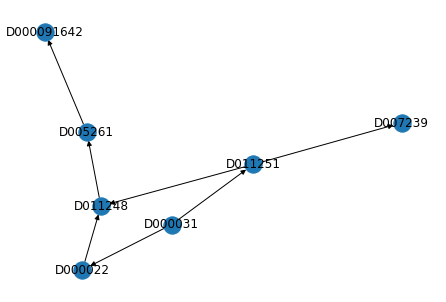

In [10]:
nx.draw(tmp_subgraph, with_labels=True)

# MiRNAs - miRBase

## aliases.txt

In [6]:
id_aliases = {}
with open('miRNA/miRBase/aliases.txt', 'r', encoding='UTF-8') as f:
    for row in f:
        row = row.strip()
        tmp_id_aliases = row.split('\t')
        if tmp_id_aliases[1][:3] == 'hsa':
            id = tmp_id_aliases[0]
            aliases = tmp_id_aliases[1].split(';')[:-1]
            id_aliases[id] = set(aliases)

In [7]:
id_aliases

{'MI0000060': {'hsa-let-7a-1', 'hsa-let-7a-1L'},
 'MI0000061': {'hsa-let-7a-2', 'hsa-let-7a-2L'},
 'MI0000062': {'hsa-let-7a-3', 'hsa-let-7a-3L'},
 'MI0000063': {'hsa-let-7b', 'hsa-let-7bL'},
 'MI0000064': {'hsa-let-7c', 'hsa-let-7cL'},
 'MI0000065': {'hsa-let-7d', 'hsa-let-7dL'},
 'MI0000066': {'hsa-let-7e', 'hsa-let-7eL'},
 'MI0000067': {'hsa-let-7f-1', 'hsa-let-7f-1L'},
 'MI0000068': {'hsa-let-7f-2', 'hsa-let-7f-2L'},
 'MI0000069': {'hsa-mir-15', 'hsa-mir-15a'},
 'MI0000070': {'hsa-mir-16', 'hsa-mir-16-1', 'hsa-mir-16-13'},
 'MI0000071': {'hsa-mir-17'},
 'MI0000072': {'hsa-mir-18', 'hsa-mir-18a'},
 'MI0000073': {'hsa-mir-19a'},
 'MI0000074': {'hsa-mir-19b-1'},
 'MI0000075': {'hsa-mir-19b-2'},
 'MI0000076': {'hsa-mir-20', 'hsa-mir-20a'},
 'MI0000077': {'hsa-mir-21'},
 'MI0000078': {'hsa-mir-22'},
 'MI0000079': {'hsa-mir-23', 'hsa-mir-23a'},
 'MI0000080': {'hsa-mir-24-1'},
 'MI0000081': {'hsa-mir-24-2'},
 'MI0000082': {'hsa-mir-25'},
 'MI0000083': {'hsa-mir-26a', 'hsa-mir-26a-1'},
 'M

## hairpin.fa

In [8]:
hairpins = SeqIO.parse('miRNA/miRBase/hairpin.fa', 'fasta')

In [9]:
# id, name, description, seq
pri_mirnas = {}
for hairpin in hairpins:
    if hairpin.name[:3] == 'hsa':
        tmp_pri_mirna = {}
        id = hairpin.description.split(' ')[1]
        tmp_pri_mirna['name'] = hairpin.name
        tmp_pri_mirna['seq'] = hairpin.seq
        tmp_pri_mirna['aliases'] = id_aliases[id]
        pri_mirnas[id] = tmp_pri_mirna
print(len(pri_mirnas))

1917


In [10]:
pri_mirnas

{'MI0000060': {'name': 'hsa-let-7a-1',
  'seq': Seq('UGGGAUGAGGUAGUAGGUUGUAUAGUUUUAGGGUCACACCCACCACUGGGAGAU...CUA'),
  'aliases': {'hsa-let-7a-1', 'hsa-let-7a-1L'}},
 'MI0000061': {'name': 'hsa-let-7a-2',
  'seq': Seq('AGGUUGAGGUAGUAGGUUGUAUAGUUUAGAAUUACAUCAAGGGAGAUAACUGUA...CCU'),
  'aliases': {'hsa-let-7a-2', 'hsa-let-7a-2L'}},
 'MI0000062': {'name': 'hsa-let-7a-3',
  'seq': Seq('GGGUGAGGUAGUAGGUUGUAUAGUUUGGGGCUCUGCCCUGCUAUGGGAUAACUA...CCU'),
  'aliases': {'hsa-let-7a-3', 'hsa-let-7a-3L'}},
 'MI0000063': {'name': 'hsa-let-7b',
  'seq': Seq('CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCCCCUCGGAA...CUG'),
  'aliases': {'hsa-let-7b', 'hsa-let-7bL'}},
 'MI0000064': {'name': 'hsa-let-7c',
  'seq': Seq('GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCUGGGAGUUA...AGC'),
  'aliases': {'hsa-let-7c', 'hsa-let-7cL'}},
 'MI0000065': {'name': 'hsa-let-7d',
  'seq': Seq('CCUAGGAAGAGGUAGUAGGUUGCAUAGUUUUAGGGCAGGGAUUUUGCCCACAAG...AGG'),
  'aliases': {'hsa-let-7d', 'hsa-let-7dL'}},
 'MI0000066': {'name':

In [39]:
pd.DataFrame({
    'ID': pri_mirnas.keys(),
    'Name': [pri_mirnas[key]['name'] for key in pri_mirnas.keys()],
    'Sequence': [pri_mirnas[key]['seq'] for key in pri_mirnas.keys()]
}).to_csv('our_data/nodes/pri_mirnas.tsv', sep='\t', index=False)

## mature.fa

In [11]:
matures = SeqIO.parse('miRNA/miRBase/mature.fa', 'fasta')

In [12]:
# id, name, description, seq
mature_mirnas = {}
for mature in matures:
    if mature.name[:3] == 'hsa':
        tmp_mature_mirna = {}
        id = mature.description.split(' ')[1]
        tmp_mature_mirna['name'] = mature.name
        tmp_mature_mirna['seq'] = mature.seq
        tmp_mature_mirna['aliases'] = id_aliases[id]
        mature_mirnas[id] = tmp_mature_mirna
print(len(mature_mirnas))

2656


In [13]:
mature_mirnas

{'MIMAT0000062': {'name': 'hsa-let-7a-5p',
  'seq': Seq('UGAGGUAGUAGGUUGUAUAGUU'),
  'aliases': {'hsa-let-7a', 'hsa-let-7a-5p'}},
 'MIMAT0004481': {'name': 'hsa-let-7a-3p',
  'seq': Seq('CUAUACAAUCUACUGUCUUUC'),
  'aliases': {'hsa-let-7a*', 'hsa-let-7a-3p'}},
 'MIMAT0010195': {'name': 'hsa-let-7a-2-3p',
  'seq': Seq('CUGUACAGCCUCCUAGCUUUCC'),
  'aliases': {'hsa-let-7a-2*', 'hsa-let-7a-2-3p'}},
 'MIMAT0000063': {'name': 'hsa-let-7b-5p',
  'seq': Seq('UGAGGUAGUAGGUUGUGUGGUU'),
  'aliases': {'hsa-let-7b', 'hsa-let-7b-5p'}},
 'MIMAT0004482': {'name': 'hsa-let-7b-3p',
  'seq': Seq('CUAUACAACCUACUGCCUUCCC'),
  'aliases': {'hsa-let-7b*', 'hsa-let-7b-3p'}},
 'MIMAT0000064': {'name': 'hsa-let-7c-5p',
  'seq': Seq('UGAGGUAGUAGGUUGUAUGGUU'),
  'aliases': {'hsa-let-7c', 'hsa-let-7c-5p'}},
 'MIMAT0026472': {'name': 'hsa-let-7c-3p',
  'seq': Seq('CUGUACAACCUUCUAGCUUUCC'),
  'aliases': {'hsa-let-7c-3p'}},
 'MIMAT0000065': {'name': 'hsa-let-7d-5p',
  'seq': Seq('AGAGGUAGUAGGUUGCAUAGUU'),
  'aliases': 

In [44]:
pd.DataFrame({
    'ID': mature_mirnas.keys(),
    'Name': [mature_mirnas[key]['name'] for key in mature_mirnas.keys()],
    'Sequence': [mature_mirnas[key]['seq'] for key in mature_mirnas.keys()]
}).to_csv('our_data/nodes/mature_mirnas.tsv', sep='\t', index=False)

In [19]:
mirna_node_list = []
for pri_mirna_id in list(pri_mirnas):
    mirna_node_list.append((pri_mirna_id, pri_mirnas[pri_mirna_id]))
for mature_mirna_id in list(mature_mirnas):
    mirna_node_list.append((mature_mirna_id, mature_mirnas[mature_mirna_id]))
print(len(mirna_node_list))

4573


## miRNA.xls

In [198]:
mirnas = pd.read_excel('miRNA/miRBase/miRNA.xls')
mirnas = mirnas[['Accession', 'ID', 'Sequence', 'Mature1_Acc', 'Mature1_ID', 'Mature1_Seq', 'Mature2_Acc', 'Mature2_ID', 'Mature2_Seq']]
mirnas = mirnas[mirnas['ID'].str.contains('hsa')]
mirnas

,Accession,ID,Sequence,Mature1_Acc,Mature1_ID,Mature1_Seq,Mature2_Acc,Mature2_ID,Mature2_Seq
57,MI0000060,hsa-let-7a-1,UGGGAUGAGGUAGUAGGUUGUAUAGUUUUAGGGUCACACCCACCAC...,MIMAT0000062,hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU,MIMAT0004481,hsa-let-7a-3p,CUAUACAAUCUACUGUCUUUC
58,MI0000061,hsa-let-7a-2,AGGUUGAGGUAGUAGGUUGUAUAGUUUAGAAUUACAUCAAGGGAGA...,MIMAT0000062,hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU,MIMAT0010195,hsa-let-7a-2-3p,CUGUACAGCCUCCUAGCUUUCC
59,MI0000062,hsa-let-7a-3,GGGUGAGGUAGUAGGUUGUAUAGUUUGGGGCUCUGCCCUGCUAUGG...,MIMAT0000062,hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU,MIMAT0004481,hsa-let-7a-3p,CUAUACAAUCUACUGUCUUUC
60,MI0000063,hsa-let-7b,CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCC...,MIMAT0000063,hsa-let-7b-5p,UGAGGUAGUAGGUUGUGUGGUU,MIMAT0004482,hsa-let-7b-3p,CUAUACAACCUACUGCCUUCCC
61,MI0000064,hsa-let-7c,GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCU...,MIMAT0000064,hsa-let-7c-5p,UGAGGUAGUAGGUUGUAUGGUU,MIMAT0026472,hsa-let-7c-3p,CUGUACAACCUUCUAGCUUUCC
...,...,...,...,...,...,...,...,...,...
37307,MI0039734,hsa-mir-12132,UUAACAUCUUUUCCAUCAUAAUUCUCAUAGUAAUAAUAGUAAUGUU...,MIMAT0049026,hsa-miR-12132,UAUUACUGUGAGAAUUAUGAUG,NaN,NaN,NaN
37308,MI0039735,hsa-mir-12133,GAAGUGUACUUUUUAAUGGUGCCAAACAGCAGUUGAUCUAUAAUAA...,MIMAT0049027,hsa-miR-12133,CUUGGCACCAUUAAAAAGUACA,NaN,NaN,NaN
37312,MI0039739,hsa-mir-12135,UGUGGAUAUUCUUUUUUGAUACUACAGCAAAACUCAGCAAGUUGUA...,MIMAT0049031,hsa-miR-12135,UAAAGGUUUGUUUGUAAA,NaN,NaN,NaN
37313,MI0039740,hsa-mir-12136,GAAAAAGUCAUGGAGGCCAUGGGGUUGGCUUGAAACCAGCUUUGGG...,MIMAT0049032,hsa-miR-12136,GAAAAAGUCAUGGAGGCC,NaN,NaN,NaN


In [11]:
mirnas.isnull().sum(axis=0)

Accession        0
ID               0
Sequence         0
Mature1_Acc      0
Mature1_ID       0
Mature1_Seq      0
Mature2_Acc    955
Mature2_ID     955
Mature2_Seq    955
dtype: int64

In [199]:
mirna_edge_list = []
for index, row in mirnas[['Accession', 'Mature1_Acc', 'Mature2_Acc']].iterrows():
    mirna_edge_list.append((row['Accession'], row['Mature1_Acc']))
    if not pd.isna(row['Mature2_Acc']):
        mirna_edge_list.append((row['Accession'], row['Mature2_Acc']))
print(len(mirna_edge_list))

2879


In [200]:
mirna_edges = pd.DataFrame({
    'ID1': [edge[0] for edge in mirna_edge_list],
    'ID2': [edge[1] for edge in mirna_edge_list]
})
mirna_edges

,ID1,ID2
0,MI0000060,MIMAT0000062
1,MI0000060,MIMAT0004481
2,MI0000061,MIMAT0000062
3,MI0000061,MIMAT0010195
4,MI0000062,MIMAT0000062
...,...,...
2874,MI0039734,MIMAT0049026
2875,MI0039735,MIMAT0049027
2876,MI0039739,MIMAT0049031
2877,MI0039740,MIMAT0049032


In [34]:
# There are 1917 human pri-miRNAs in the file hairpin.fa
print('How many Accessions are included:', mirna_edges['ID1'].drop_duplicates().isin(pri_mirnas.keys()).sum())
# There are 2656 human mature miRNAs in the file mature.fa
print('How many Mature_Accs are included:', mirna_edges['ID2'].drop_duplicates().isin(mature_mirnas.keys()).sum())

How many Accessions are included: 1917
How many Mature_Accs are included: 2656


In [54]:
mirna_edges.to_csv('our_data/edges/pri_mirna_mature_mirna.tsv', sep='\t', index=False)

In [24]:
# Have a look at those mature miRNAs with more than one pri-miRNAs
mirna_edges[mirna_edges['ID2'].isin(mirna_edges['ID2'].value_counts().index[mirna_edges['ID2'].value_counts() > 1])]

,ID1,ID2
0,MI0000060,MIMAT0000062
1,MI0000060,MIMAT0004481
2,MI0000061,MIMAT0000062
4,MI0000062,MIMAT0000062
5,MI0000062,MIMAT0004481
...,...,...
2799,MI0031521,MIMAT0027618
2800,MI0031521,MIMAT0027619
2801,MI0031522,MIMAT0022494
2806,MI0031830,MIMAT0039322


In [39]:
# Make sure that the sequence records are consistent between fa and xls files
for index, row in mirnas.iterrows():
    if pri_mirnas[row['Accession']]['seq'] != row['Sequence']:
        print(row['Accession'])
    if mature_mirnas[row['Mature1_Acc']]['seq'] != row['Mature1_Seq']:
        print(row['Mature1_Acc'])
    if not pd.isna(row['Mature2_Acc']):
        if mature_mirnas[row['Mature2_Acc']]['seq'] != row['Mature2_Seq']:
            print(row['Mature2_Acc'])

In [36]:
mirnas.to_csv('our_data/nodes/mirnas.tsv', sep='\t', index=False)

## miFam.dat

In [68]:
mirna_families = {}
with open('miRNA/miRBase/miFam.dat', 'r', encoding='UTF-8') as f:
    for row in f:
        row = row.strip()
        if row[:2] == 'AC':
            tmp_mirna_family = {
                'id': row[5:],
                'name': '',
                'members': set()
            }
        elif row[:2] == 'ID':
            tmp_mirna_family['name'] = row[5:]
        elif row[:2] == 'MI':
            if row[16:19] == 'hsa':
                tmp_mirna_family['members'].add(row[5:14])
                # tmp_mirna_family['members'].add((row[5:14], row[16:])) # .add( (ID, Name) )
        elif row == '//':
            if len(tmp_mirna_family['members']) > 0:
                mirna_families[tmp_mirna_family['id']] = tmp_mirna_family
print(len(mirna_families))

589


In [69]:
mirna_families

{'MIPF0000001': {'id': 'MIPF0000001',
  'name': 'mir-17',
  'members': {'MI0000071',
   'MI0000072',
   'MI0000076',
   'MI0000095',
   'MI0000113',
   'MI0000734',
   'MI0001518',
   'MI0001519'}},
 'MIPF0000002': {'id': 'MIPF0000002',
  'name': 'let-7',
  'members': {'MI0000060',
   'MI0000061',
   'MI0000062',
   'MI0000063',
   'MI0000064',
   'MI0000065',
   'MI0000066',
   'MI0000067',
   'MI0000068',
   'MI0000100',
   'MI0000433',
   'MI0000434'}},
 'MIPF0000005': {'id': 'MIPF0000005',
  'name': 'mir-30',
  'members': {'MI0000088',
   'MI0000254',
   'MI0000255',
   'MI0000441',
   'MI0000736',
   'MI0000749'}},
 'MIPF0000006': {'id': 'MIPF0000006',
  'name': 'mir-15',
  'members': {'MI0000069',
   'MI0000070',
   'MI0000115',
   'MI0000438',
   'MI0000489'}},
 'MIPF0000007': {'id': 'MIPF0000007',
  'name': 'mir-181',
  'members': {'MI0000269',
   'MI0000270',
   'MI0000271',
   'MI0000289',
   'MI0000683',
   'MI0003139'}},
 'MIPF0000009': {'id': 'MIPF0000009',
  'name': 'mir-

In [71]:
pd.DataFrame({
    'ID': mirna_families.keys(),
    'Name': [mirna_families[key]['name'] for key in mirna_families.keys()],
    'Members': [','.join(list(member)) for member in [mirna_families[key]['members'] for key in mirna_families.keys()]]
}).to_csv('our_data/nodes/mirna_families.tsv', sep='\t', index=False)

In [77]:
mirna_family_edge_list = []
for mirna_family_id in mirna_families.keys():
    mirna_family = mirna_families[mirna_family_id]
    members = list(mirna_family['members'])
    # print(members)
    member_num = len(members)
    for i in range(member_num - 1):
        for j in range(i + 1, member_num):
            mirna_family_edge_list.append((members[i], members[j]))
            # print((members[i], members[j]))
print(len(mirna_family_edge_list))

4513


In [79]:
pd.DataFrame({
    'ID1': [edge[0] for edge in mirna_family_edge_list],
    'ID2': [edge[1] for edge in mirna_family_edge_list]
}).to_csv('our_data/edges/families_pri_mirna_pri_mirna.tsv', sep='\t', index=False)

# MRNA - HGNC

In [2]:
mrnas_hgnc = pd.read_table('mRNA/HGNC/protein-coding_gene.txt')
mrnas_hgnc.head(3)

C:\Users\15259\AppData\Local\Temp\ipykernel_44728\699956299.py:1: DtypeWarning: Columns (31,38) have mixed types. Specify dtype option on import or set low_memory=False.
  mrnas_hgnc = pd.read_table('mRNA/HGNC/protein-coding_gene.txt')


,hgnc_id,symbol,name,locus_group,locus_type,status,location,location_sortable,alias_symbol,alias_name,...,cd,lncrnadb,enzyme_id,intermediate_filament_db,rna_central_ids,lncipedia,gtrnadb,agr,mane_select,gencc
0,HGNC:5,A1BG,alpha-1-B glycoprotein,protein-coding gene,gene with protein product,Approved,19q13.43,19q13.43,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:5,ENST00000263100.8|NM_130786.4,NaN
1,HGNC:24086,A1CF,APOBEC1 complementation factor,protein-coding gene,gene with protein product,Approved,10q11.23,10q11.23,ACF|ASP|ACF64|ACF65|APOBEC1CF,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:24086,ENST00000373997.8|NM_014576.4,NaN
2,HGNC:7,A2M,alpha-2-macroglobulin,protein-coding gene,gene with protein product,Approved,12p13.31,12p13.31,FWP007|S863-7|CPAMD5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:7,ENST00000318602.12|NM_000014.6,HGNC:7


In [3]:
mrnas_hgnc.columns

Index(['hgnc_id', 'symbol', 'name', 'locus_group', 'locus_type', 'status',
       'location', 'location_sortable', 'alias_symbol', 'alias_name',
       'prev_symbol', 'prev_name', 'gene_group', 'gene_group_id',
       'date_approved_reserved', 'date_symbol_changed', 'date_name_changed',
       'date_modified', 'entrez_id', 'ensembl_gene_id', 'vega_id', 'ucsc_id',
       'ena', 'refseq_accession', 'ccds_id', 'uniprot_ids', 'pubmed_id',
       'mgd_id', 'rgd_id', 'lsdb', 'cosmic', 'omim_id', 'mirbase', 'homeodb',
       'snornabase', 'bioparadigms_slc', 'orphanet', 'pseudogene.org',
       'horde_id', 'merops', 'imgt', 'iuphar', 'kznf_gene_catalog',
       'mamit-trnadb', 'cd', 'lncrnadb', 'enzyme_id',
       'intermediate_filament_db', 'rna_central_ids', 'lncipedia', 'gtrnadb',
       'agr', 'mane_select', 'gencc'],
      dtype='object')

In [4]:
mrnas_hgnc[['locus_group', 'locus_type']].drop_duplicates()

,locus_group,locus_type
0,protein-coding gene,gene with protein product


In [5]:
mrnas_hgnc = mrnas_hgnc[['hgnc_id', 'symbol', 'name', 'alias_symbol', 'alias_name', 'prev_symbol', 'prev_name', 'gene_group', 'gene_group_id', 'entrez_id', 'ensembl_gene_id']]
mrnas_hgnc

,hgnc_id,symbol,name,alias_symbol,alias_name,prev_symbol,prev_name,gene_group,gene_group_id,entrez_id,ensembl_gene_id
0,HGNC:5,A1BG,alpha-1-B glycoprotein,NaN,NaN,NaN,NaN,Immunoglobulin like domain containing,594,1,ENSG00000121410
1,HGNC:24086,A1CF,APOBEC1 complementation factor,ACF|ASP|ACF64|ACF65|APOBEC1CF,NaN,NaN,NaN,RNA binding motif containing,725,29974,ENSG00000148584
2,HGNC:7,A2M,alpha-2-macroglobulin,FWP007|S863-7|CPAMD5,NaN,NaN,NaN,Alpha-2-macroglobulin family,2148,2,ENSG00000175899
3,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,FLJ25179|p170,NaN,CPAMD9,"C3 and PZP-like, alpha-2-macroglobulin domain ...",Alpha-2-macroglobulin family,2148,144568,ENSG00000166535
4,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",IGBS3S|IGB3S,iGb3 synthase|isoglobotriaosylceramide synthase,A3GALT2P,"alpha 1,3-galactosyltransferase 2, pseudogene",Glycosyltransferase family 6,429,127550,ENSG00000184389
...,...,...,...,...,...,...,...,...,...,...,...
19224,HGNC:32058,ZYG11A,"zyg-11 family member A, cell cycle regulator",ZYG11,NaN,NaN,zyg-11 homolog A (C. elegans),ZYG11 cell cycle regulator family|Armadillo li...,6|1492,440590,ENSG00000203995
19225,HGNC:25820,ZYG11B,"zyg-11 family member B, cell cycle regulator",FLJ13456,NaN,ZYG11,zyg-11 homolog (C. elegans)|zyg-11 homolog B (...,ZYG11 cell cycle regulator family|Armadillo li...,6|1492,79699,ENSG00000162378
19226,HGNC:13200,ZYX,zyxin,NaN,NaN,NaN,NaN,Zyxin family|MicroRNA protein coding host genes,1402|1691,7791,ENSG00000159840
19227,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,KIAA0399|ZZZ4|FLJ10821,NaN,NaN,"zinc finger, ZZ-type with EF hand domain 1",Zinc fingers ZZ-type|EF-hand domain containing,91|863,23140,ENSG00000074755


In [6]:
mrnas_hgnc.isna().sum()

hgnc_id                0
symbol                 0
name                   0
alias_symbol        3697
alias_name         12871
prev_symbol        12059
prev_name           5945
gene_group          4905
gene_group_id       4905
entrez_id              0
ensembl_gene_id       37
dtype: int64

In [7]:
mrnas_hgnc[['symbol', 'entrez_id']].drop_duplicates(subset=['entrez_id'])

,symbol,entrez_id
0,A1BG,1
1,A1CF,29974
2,A2M,2
3,A2ML1,144568
4,A3GALT2,127550
...,...,...
19224,ZYG11A,440590
19225,ZYG11B,79699
19226,ZYX,7791
19227,ZZEF1,23140


In [8]:
mrnas = {}
for index, row in mrnas_hgnc.iterrows():
    tmp_mrna = {
        'symbol': row['symbol'],
        'name': row['name'],
        'ensembl_gene_id': '',
        'alias_symbols': set(),
        'alias_names': set(),
        'prev_symbols': set(),
        'prev_names': set(),
        'gene_groups': set(),
        'gene_group_ids': set()
    }
    if not pd.isna(row['ensembl_gene_id']):
        tmp_mrna['ensembl_gene_id'] = row['ensembl_gene_id']
    if not pd.isna(row['alias_symbol']):
        tmp_mrna['alias_symbols'] = set(row['alias_symbol'].split('|'))
    if not pd.isna(row['alias_name']):
        tmp_mrna['alias_names'] = set(row['alias_name'].split('|'))
    if not pd.isna(row['prev_symbol']):
        tmp_mrna['prev_symbols'] = set(row['prev_symbol'].split('|'))
    if not pd.isna(row['prev_name']):
        tmp_mrna['prev_names'] = set(row['prev_name'].split('|'))
    if not pd.isna(row['gene_group']):
        tmp_mrna['gene_groups'] = set(row['gene_group'].split('|'))
    if not pd.isna(row['gene_group_id']):
        tmp_mrna['gene_group_ids'] = set(row['gene_group_id'].split('|'))
    mrnas[str(row['entrez_id'])] = tmp_mrna
print(len(mrnas))

19229


In [9]:
mrnas

{'1': {'symbol': 'A1BG',
  'name': 'alpha-1-B glycoprotein',
  'ensembl_gene_id': 'ENSG00000121410',
  'alias_symbols': set(),
  'alias_names': set(),
  'prev_symbols': set(),
  'prev_names': set(),
  'gene_groups': {'Immunoglobulin like domain containing'},
  'gene_group_ids': {'594'}},
 '29974': {'symbol': 'A1CF',
  'name': 'APOBEC1 complementation factor',
  'ensembl_gene_id': 'ENSG00000148584',
  'alias_symbols': {'ACF', 'ACF64', 'ACF65', 'APOBEC1CF', 'ASP'},
  'alias_names': set(),
  'prev_symbols': set(),
  'prev_names': set(),
  'gene_groups': {'RNA binding motif containing'},
  'gene_group_ids': {'725'}},
 '2': {'symbol': 'A2M',
  'name': 'alpha-2-macroglobulin',
  'ensembl_gene_id': 'ENSG00000175899',
  'alias_symbols': {'CPAMD5', 'FWP007', 'S863-7'},
  'alias_names': set(),
  'prev_symbols': set(),
  'prev_names': set(),
  'gene_groups': {'Alpha-2-macroglobulin family'},
  'gene_group_ids': {'2148'}},
 '144568': {'symbol': 'A2ML1',
  'name': 'alpha-2-macroglobulin like 1',
  

In [14]:
pd.DataFrame({
    'ID': mrnas.keys(),
    'Symbol': [mrnas[key]['symbol'] for key in mrnas.keys()],
    'Name': [mrnas[key]['name'] for key in mrnas.keys()],
    'Gene Groups': [', '.join(mrnas[key]['gene_groups']) for key in mrnas.keys()]
}).to_csv('our_data/nodes/mrnas.tsv', sep='\t', index=False)

In [95]:
mrna_gene_groups = {}
for index, row in mrnas_hgnc[['gene_group', 'gene_group_id', 'entrez_id']].iterrows():
    if not pd.isna(row['gene_group_id']):
        tmp_gene_groups = row['gene_group'].split('|')
        tmp_gene_group_ids = row['gene_group_id'].split('|')
        for i in range(len(tmp_gene_group_ids)):
            if tmp_gene_group_ids[i] in mrna_gene_groups.keys():
                mrna_gene_groups[tmp_gene_group_ids[i]]['members'].add(str(row['entrez_id']))
            else:
                mrna_gene_groups[tmp_gene_group_ids[i]] = {
                    'name': tmp_gene_groups[i],
                    'members': set([str(row['entrez_id'])])
                }
print(len(mrna_gene_groups))
mrna_gene_groups

1397


{'594': {'name': 'Immunoglobulin like domain containing',
  'members': {'1',
   '10068',
   '10223',
   '10225',
   '10371',
   '10507',
   '10892',
   '11055',
   '11122',
   '11126',
   '115350',
   '115352',
   '124626',
   '126014',
   '126259',
   '1271',
   '127943',
   '1436',
   '147645',
   '147710',
   '148113',
   '151888',
   '2204',
   '2205',
   '2209',
   '2212',
   '2213',
   '221395',
   '2214',
   '2215',
   '2322',
   '25960',
   '26280',
   '284021',
   '284415',
   '285025',
   '3383',
   '3384',
   '3385',
   '3386',
   '343413',
   '347902',
   '3547',
   '3556',
   '3570',
   '3590',
   '3593',
   '3815',
   '386724',
   '388730',
   '3902',
   '3903',
   '3904',
   '3953',
   '4063',
   '4345',
   '441864',
   '4593',
   '4914',
   '51206',
   '51599',
   '51744',
   '5175',
   '54910',
   '56833',
   '56920',
   '57188',
   '57611',
   '57715',
   '5796',
   '59307',
   '6405',
   '6504',
   '7010',
   '7070',
   '7075',
   '7087',
   '7850',
   '7869',
   '79

In [97]:
pd.DataFrame({
    'ID': mrna_gene_groups.keys(),
    'Name': [mrna_gene_groups[key]['name'] for key in mrna_gene_groups.keys()],
    'Members': [','.join(list(mrna_gene_groups[key]['members'])) for key in mrna_gene_groups.keys()]
}).to_csv('our_data/nodes/mrna_groups.tsv', sep='\t', index=False)

In [98]:
mrna_group_edge_list = []
for mrna_group_id in mrna_gene_groups.keys():
    mrna_group = mrna_gene_groups[mrna_group_id]
    members = list(mrna_group['members'])
    # print(members)
    member_num = len(members)
    for i in range(member_num - 1):
        for j in range(i + 1, member_num):
            mrna_group_edge_list.append((members[i], members[j]))
            # print((members[i], members[j]))
print(len(mrna_group_edge_list))

1246065


In [100]:
pd.DataFrame({
    'ID1': [edge[0] for edge in mrna_group_edge_list],
    'ID2': [edge[1] for edge in mrna_group_edge_list]
}).to_csv('our_data/edges/groups_mrna_mrna.tsv', sep='\t', index=False)

# MiRNA-Disease - RNADisease

## RNADiseasev4.0_RNA-disease_experiment_miRNA.xlsx

In [57]:
mda_rnadisease = pd.read_excel('associations/RNADisease/RNADiseasev4.0_RNA-disease_experiment_miRNA.xlsx')
mda_rnadisease

,RDID,specise,RNA Symbol,RNA Type,Disease Name,DO ID,MeSH ID,KEGG disease ID,PMID,score
0,RD-E-mi-00088983,Homo sapiens,AP001273.1,miRNA,Pancreatic Neuroendocrine Tumor,NaN,NaN,NaN,32183367.0,0.999831
1,RD-E-mi-00088984,Homo sapiens,AP001524.1,miRNA,Pancreatic Neuroendocrine Tumor,NaN,NaN,NaN,32183367.0,0.999831
2,RD-E-mi-00089413,Caenorhabditis elegans,cel-let-7,miRNA,Alzheimer Disease,DOID:10652,D000544,NaN,18262516.0,0.973352
3,RD-E-mi-00089414,Caenorhabditis elegans,cel-let-7,miRNA,Parkinson Disease,DOID:14330,D010300,NaN,20091141.0,0.328976
4,RD-E-mi-00090759,Homo sapiens,hsa-let-7a-1,miRNA,Acth-Independent Macronodular Adrenal Hyperplasia,NaN,NaN,NaN,18840638.0,0.694506
...,...,...,...,...,...,...,...,...,...,...
214381,RD-E-mi-00303270,Sus scrofa,vsRNA_15627,miRNA,Adverse Response To Chemotherapy(Neutropenia/L...,NaN,NaN,NaN,34481273.0,0.968971
214382,RD-E-mi-00303271,Sus scrofa,vsRNA_15766,miRNA,Adverse Response To Chemotherapy(Neutropenia/L...,NaN,NaN,NaN,34481273.0,0.968971
214383,RD-E-mi-00303272,Sus scrofa,vsRNA_17027,miRNA,Adverse Response To Lamotrigine And Phenytoin,NaN,NaN,NaN,34481273.0,0.968971
214384,RD-E-mi-00303273,Sus scrofa,vsRNA_7505,miRNA,Affective Disorder,NaN,NaN,NaN,34481273.0,0.968971


In [58]:
print('Originally:', mda_rnadisease.shape[0], 'rows')
mda_rnadisease = mda_rnadisease[mda_rnadisease['specise'] == 'Homo sapiens']
print('Homo sapiens only:', mda_rnadisease.shape[0], 'rows')
mda_rnadisease = mda_rnadisease[['RNA Symbol', 'Disease Name', 'MeSH ID', 'PMID', 'score']]
mda_rnadisease = mda_rnadisease.dropna(subset=['PMID'])
print('With PMID:', mda_rnadisease.shape[0], 'rows')
mda_rnadisease

Originally: 214386 rows
Homo sapiens only: 192536 rows
With PMID: 159415 rows


,RNA Symbol,Disease Name,MeSH ID,PMID,score
0,AP001273.1,Pancreatic Neuroendocrine Tumor,NaN,32183367.0,0.999831
1,AP001524.1,Pancreatic Neuroendocrine Tumor,NaN,32183367.0,0.999831
4,hsa-let-7a-1,Acth-Independent Macronodular Adrenal Hyperplasia,NaN,18840638.0,0.694506
5,hsa-let-7a-1,Acth-Secreting Pituitary Adenoma,D049913,18840638.0,0.694506
6,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,17363563.0,0.973352
...,...,...,...,...,...
213973,solexa-3277-272,Pancreatic Cancer,D010190,25149530.0,0.328976
213974,solexa-578-1915,Pancreatic Cancer,D010190,25149530.0,0.328976
213975,solexa-826-1288,Pancreatic Cancer,D010190,25149530.0,0.328976
214377,unconservative_12_239971,Drug-Induced Liver Injury,D056486,32355577.0,0.328976


## Match to MeSH terms

In [59]:
mda_rnadisease.isna().sum(axis=0)

RNA Symbol          0
Disease Name        0
MeSH ID         25083
PMID                0
score               0
dtype: int64

In [60]:
rnadisease_diseasename_meshid = {}
count1 = 0
count2 = 0
for disease in mda_rnadisease[mda_rnadisease['MeSH ID'].isna()]['Disease Name'].drop_duplicates():
    # A special phenomenon in RNADisease: No word 'Neoplasms', there is only 'Neoplasm'.
    disease = relo(disease.lower().replace('neoplasm', 'neoplasms'))
    for unique_id in mesh_terms.keys():
        tmp_mesh_term = mesh_terms[unique_id]
        if disease == relo(tmp_mesh_term['heading']):
            rnadisease_diseasename_meshid[disease] = unique_id
            count1 = count1 + 1
            break
        if disease in tmp_mesh_term['entries']:
            rnadisease_diseasename_meshid[disease] = unique_id
            count2 = count2 + 1
            break
print('matched to the heading:', count1)
print('matched to the entries:', count2)
rnadisease_diseasename_meshid

matched to the heading: 101
matched to the entries: 131


{('breast', 'neoplasms'): 'D001943',
 ('colon', 'neoplasms'): 'D003110',
 ('digestive', 'neoplasms', 'system'): 'D004067',
 ('endometrial', 'neoplasms'): 'D016889',
 ('gastric', 'neoplasms'): 'D013274',
 ('gastrointestinal', 'neoplasms'): 'D005770',
 ('and', 'head', 'neck', 'neoplasms'): 'D006258',
 ('failure', 'heart'): 'D006333',
 ('inflammation',): 'D007249',
 ('lung', 'neoplasms'): 'D008175',
 ('leukemia', 'myelogenous'): 'D007951',
 ('neoplasms',): 'D009369',
 ('carcinoma', 'cell', 'oral', 'squamous'): 'D000077195',
 ('neoplasms', 'ovarian'): 'D010051',
 ('neoplasms', 'pituitary'): 'D010911',
 ('neoplasms', 'prostate'): 'D011471',
 ('gland', 'neoplasms', 'salivary'): 'D012468',
 ('brain', 'neoplasms', 'stem'): 'D020295',
 ('carcinosarcoma',): 'D002296',
 ('adenoma', 'follicular'): 'D000236',
 ('dysplasia', 'ectodermal', 'hypohidrotic'): 'D053358',
 ('disease', 'heart', 'ischemic'): 'D017202',
 ('liver', 'neoplasms'): 'D008113',
 ('disease', 'pancreatic'): 'D010182',
 ('inhalation'

In [61]:
for index, row in mda_rnadisease[mda_rnadisease['MeSH ID'].isna()].iterrows():
    disease = relo(row['Disease Name'].lower().replace('neoplasm', 'neoplasms'))
    if disease in rnadisease_diseasename_meshid.keys():
        mda_rnadisease.loc[index, 'MeSH ID'] = rnadisease_diseasename_meshid[disease]
mda_rnadisease

,RNA Symbol,Disease Name,MeSH ID,PMID,score
0,AP001273.1,Pancreatic Neuroendocrine Tumor,NaN,32183367.0,0.999831
1,AP001524.1,Pancreatic Neuroendocrine Tumor,NaN,32183367.0,0.999831
4,hsa-let-7a-1,Acth-Independent Macronodular Adrenal Hyperplasia,NaN,18840638.0,0.694506
5,hsa-let-7a-1,Acth-Secreting Pituitary Adenoma,D049913,18840638.0,0.694506
6,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,17363563.0,0.973352
...,...,...,...,...,...
213973,solexa-3277-272,Pancreatic Cancer,D010190,25149530.0,0.328976
213974,solexa-578-1915,Pancreatic Cancer,D010190,25149530.0,0.328976
213975,solexa-826-1288,Pancreatic Cancer,D010190,25149530.0,0.328976
214377,unconservative_12_239971,Drug-Induced Liver Injury,D056486,32355577.0,0.328976


In [20]:
mda_rnadisease[mda_rnadisease['MeSH ID'].isna()]

,RNA Symbol,Disease Name,MeSH ID,PMID,score
0,AP001273.1,Pancreatic Neuroendocrine Tumor,NaN,32183367.0,0.999831
1,AP001524.1,Pancreatic Neuroendocrine Tumor,NaN,32183367.0,0.999831
4,hsa-let-7a-1,Acth-Independent Macronodular Adrenal Hyperplasia,NaN,18840638.0,0.694506
57,hsa-let-7a-1,Colorectal Adenocarcinoma,NaN,20413677.0,0.328976
87,hsa-let-7a-1,Glioblastoma Multiforme Somatic,NaN,17363563.0,0.694506
...,...,...,...,...,...
213941,SCoV-2-miR-5,Sars-Cov2,NaN,34159729.0,0.328976
213942,SCoV-2-miR-6,Sars-Cov2,NaN,34159729.0,0.328976
213943,SCoV-2-miR-7,Sars-Cov2,NaN,34159729.0,0.328976
213944,SCoV-2-miR-8,Sars-Cov2,NaN,34159729.0,0.328976


In [19]:
mda_rnadisease.isna().sum(axis=0)

RNA Symbol          0
Disease Name        0
MeSH ID         11378
PMID                0
score               0
dtype: int64

In [20]:
mda_rnadisease = mda_rnadisease[mda_rnadisease['MeSH ID'].isin(mesh_terms.keys())]
print('Matched to MeSH terms:', mda_rnadisease.shape[0], 'rows')
mda_rnadisease

Matched to MeSH terms: 144114 rows


,RNA Symbol,Disease Name,MeSH ID,PMID,score
5,hsa-let-7a-1,Acth-Secreting Pituitary Adenoma,D049913,18840638.0,0.694506
6,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,17363563.0,0.973352
7,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,18308931.0,0.973352
8,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,20425795.0,0.973352
9,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,23676502.0,0.973352
...,...,...,...,...,...
213973,solexa-3277-272,Pancreatic Cancer,D010190,25149530.0,0.328976
213974,solexa-578-1915,Pancreatic Cancer,D010190,25149530.0,0.328976
213975,solexa-826-1288,Pancreatic Cancer,D010190,25149530.0,0.328976
214377,unconservative_12_239971,Drug-Induced Liver Injury,D056486,32355577.0,0.328976


## Match to miRBase

In [21]:
rnadisease_rnaname_mirbaseid = {}
count1 = 0
count2 = 0
count3 = 0
count4 = 0
for rna_name in mda_rnadisease['RNA Symbol'].drop_duplicates():
    flag = True
    for mature_mirna_id in mature_mirnas.keys():
        tmp_mature_mirna = mature_mirnas[mature_mirna_id]
        if rna_name == tmp_mature_mirna['name']:
            flag = False
            rnadisease_rnaname_mirbaseid[rna_name] = mature_mirna_id
            count1 = count1 + 1
            break
        if rna_name in tmp_mature_mirna['aliases']:
            flag = False
            rnadisease_rnaname_mirbaseid[rna_name] = mature_mirna_id
            count2 = count2 + 1
            break
    if flag:
        for pri_mirna_id in pri_mirnas.keys():
            tmp_pri_mirna = pri_mirnas[pri_mirna_id]
            if rna_name == tmp_pri_mirna['name']:
                rnadisease_rnaname_mirbaseid[rna_name] = pri_mirna_id
                count3 = count3 + 1
                break
            if rna_name in tmp_pri_mirna['aliases']:
                rnadisease_rnaname_mirbaseid[rna_name] = pri_mirna_id
                count4 = count4 + 1
                break
print('Mature miRNA, name:', count1)
print('Mature miRNA, aliases:', count2)
print('Pri-miRNA, name', count3)
print('Pri-miRNA, aliases:', count4)
rnadisease_rnaname_mirbaseid

Mature miRNA, name: 2588
Mature miRNA, aliases: 90
Pri-miRNA, name 326
Pri-miRNA, aliases: 22


{'hsa-let-7a-1': 'MI0000060',
 'hsa-let-7a-2': 'MI0000061',
 'hsa-let-7a-3': 'MI0000062',
 'hsa-let-7b': 'MIMAT0000063',
 'hsa-let-7c': 'MIMAT0000064',
 'hsa-let-7d': 'MIMAT0000065',
 'hsa-let-7e': 'MIMAT0000066',
 'hsa-let-7f-1': 'MI0000067',
 'hsa-let-7f-2': 'MI0000068',
 'hsa-mir-15a': 'MI0000069',
 'hsa-mir-16-1': 'MI0000070',
 'hsa-mir-17': 'MI0000071',
 'hsa-mir-18a': 'MI0000072',
 'hsa-mir-19a': 'MI0000073',
 'hsa-mir-19b-1': 'MI0000074',
 'hsa-mir-19b-2': 'MI0000075',
 'hsa-mir-20a': 'MI0000076',
 'hsa-mir-21': 'MI0000077',
 'hsa-mir-22': 'MI0000078',
 'hsa-mir-23a': 'MI0000079',
 'hsa-mir-24-1': 'MI0000080',
 'hsa-mir-25': 'MI0000082',
 'hsa-mir-26a-1': 'MI0000083',
 'hsa-mir-26b': 'MI0000084',
 'hsa-mir-27a': 'MI0000085',
 'hsa-mir-28': 'MI0000086',
 'hsa-mir-29a': 'MI0000087',
 'hsa-mir-30a': 'MI0000088',
 'hsa-mir-31': 'MI0000089',
 'hsa-mir-32': 'MI0000090',
 'hsa-mir-33a': 'MI0000091',
 'hsa-mir-92a-1': 'MI0000093',
 'hsa-mir-92a-2': 'MI0000094',
 'hsa-mir-93': 'MI0000095

In [22]:
mda_rnadisease = mda_rnadisease.join(
    pd.DataFrame(
        {'miRBase ID': rnadisease_rnaname_mirbaseid.values()}, 
        index=rnadisease_rnaname_mirbaseid.keys()
    ), on='RNA Symbol'
)
mda_rnadisease

,RNA Symbol,Disease Name,MeSH ID,PMID,score,miRBase ID
5,hsa-let-7a-1,Acth-Secreting Pituitary Adenoma,D049913,18840638.0,0.694506,MI0000060
6,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,17363563.0,0.973352,MI0000060
7,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,18308931.0,0.973352,MI0000060
8,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,20425795.0,0.973352,MI0000060
9,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,23676502.0,0.973352,MI0000060
...,...,...,...,...,...,...
213973,solexa-3277-272,Pancreatic Cancer,D010190,25149530.0,0.328976,NaN
213974,solexa-578-1915,Pancreatic Cancer,D010190,25149530.0,0.328976,NaN
213975,solexa-826-1288,Pancreatic Cancer,D010190,25149530.0,0.328976,NaN
214377,unconservative_12_239971,Drug-Induced Liver Injury,D056486,32355577.0,0.328976,NaN


In [23]:
mda_rnadisease = mda_rnadisease.dropna(subset=['miRBase ID'])
print('Matched to miRBase:', mda_rnadisease.shape[0], 'rows')
mda_rnadisease

Matched to miRBase: 137217 rows


,RNA Symbol,Disease Name,MeSH ID,PMID,score,miRBase ID
5,hsa-let-7a-1,Acth-Secreting Pituitary Adenoma,D049913,18840638.0,0.694506,MI0000060
6,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,17363563.0,0.973352,MI0000060
7,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,18308931.0,0.973352,MI0000060
8,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,20425795.0,0.973352,MI0000060
9,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,23676502.0,0.973352,MI0000060
...,...,...,...,...,...,...
210373,hsa-miR-92,T-Cell Leukemia,D015458,15944707.0,0.994838,MIMAT0000092
210374,hsa-miR-92,Temporal Lobe Epilepsy,D004833,22615744.0,0.328976,MIMAT0000092
210375,hsa-miR-92,Tonsil Cancer,D014067,26867589.0,0.328976,MIMAT0000092
210376,hsa-miR-92,Vascular Disease,D014652,28464406.0,0.328976,MIMAT0000092


## Bio.Entrez Year

In [24]:
mda_rnadisease['PMID'] = mda_rnadisease['PMID'].astype(int).astype(str)
mda_rnadisease

C:\Users\15259\AppData\Local\Temp\ipykernel_2928\552645976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mda_rnadisease['PMID'] = mda_rnadisease['PMID'].astype(int).astype(str)


,RNA Symbol,Disease Name,MeSH ID,PMID,score,miRBase ID
5,hsa-let-7a-1,Acth-Secreting Pituitary Adenoma,D049913,18840638,0.694506,MI0000060
6,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,17363563,0.973352,MI0000060
7,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,18308931,0.973352,MI0000060
8,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,20425795,0.973352,MI0000060
9,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,23676502,0.973352,MI0000060
...,...,...,...,...,...,...
210373,hsa-miR-92,T-Cell Leukemia,D015458,15944707,0.994838,MIMAT0000092
210374,hsa-miR-92,Temporal Lobe Epilepsy,D004833,22615744,0.328976,MIMAT0000092
210375,hsa-miR-92,Tonsil Cancer,D014067,26867589,0.328976,MIMAT0000092
210376,hsa-miR-92,Vascular Disease,D014652,28464406,0.328976,MIMAT0000092


In [25]:
pmid_list = mda_rnadisease['PMID'].drop_duplicates().values
print(len(pmid_list))
pmid_lists = [
    ','.join(pmid_list[:9999]), 
    ','.join(pmid_list[9999: 9999 * 2]), 
    ','.join(pmid_list[9999 * 2: 9999 * 3]), 
    ','.join(pmid_list[9999 * 3:])
]

36297


In [26]:
rnadisese_pmid_year = {}
Entrez.email = 'zhouyi2@stu.scu.edu.cn'
handle = Entrez.efetch(db='pubmed', id=pmid_lists[0], retmod='xml')
records = handle.read()
print('Got Data!')
result = BeautifulSoup(records, 'xml')
# with open('our_data/rnadisease_pubmed_records_1.xml', 'w', encoding='utf-8') as f:
#     f.write(result.prettify())
rnadiseaes_articles = result.find_all('PubmedArticle')
print(len(rnadiseaes_articles))
for article in rnadiseaes_articles:
    rnadisese_pmid_year[article.find('PMID').text] = article.find('Year').text
print(len(rnadisese_pmid_year))
# pd.DataFrame({'PMID': rnadisese_pmid_year.keys(), 'Year': rnadisese_pmid_year.values()}).to_csv('our_data/csv/rnadisese_pmid_year_1.csv')

Got Data!
9986
9986


In [28]:
Entrez.email = 'zhouyi2@stu.scu.edu.cn'
handle = Entrez.efetch(db='pubmed', id=pmid_lists[1], retmod='xml')
records = handle.read()
print('Got Data!')
result = BeautifulSoup(records, 'xml')
# with open('our_data/rnadisease_pubmed_records_2.xml', 'w', encoding='utf-8') as f:
#     f.write(result.prettify())
rnadiseaes_articles = result.find_all('PubmedArticle')
print(len(rnadiseaes_articles))
for article in rnadiseaes_articles:
    rnadisese_pmid_year[article.find('PMID').text] = article.find('Year').text
print(len(rnadisese_pmid_year))
# pd.DataFrame({'PMID': rnadisese_pmid_year.keys(), 'Year': rnadisese_pmid_year.values()}).to_csv('our_data/csv/rnadisese_pmid_year_2.csv')

Got Data!
9990
19976


In [31]:
Entrez.email = 'zhouyi2@stu.scu.edu.cn'
handle = Entrez.efetch(db='pubmed', id=pmid_lists[2], retmod='xml')
records = handle.read()
print('Got Data!')
result = BeautifulSoup(records, 'xml')
# with open('our_data/rnadisease_pubmed_records_3.xml', 'w', encoding='utf-8') as f:
#     f.write(result.prettify())
rnadiseaes_articles = result.find_all('PubmedArticle')
print(len(rnadiseaes_articles))
for article in rnadiseaes_articles:
    rnadisese_pmid_year[article.find('PMID').text] = article.find('Year').text
print(len(rnadisese_pmid_year))
# pd.DataFrame({'PMID': rnadisese_pmid_year.keys(), 'Year': rnadisese_pmid_year.values()}).to_csv('our_data/csv/rnadisese_pmid_year_3.csv')

Got Data!
9984
29960


In [32]:
Entrez.email = 'zhouyi2@stu.scu.edu.cn'
handle = Entrez.efetch(db='pubmed', id=pmid_lists[3], retmod='xml')
records = handle.read()
print('Got Data!')
result = BeautifulSoup(records, 'xml')
# with open('our_data/rnadisease_pubmed_records_4.xml', 'w', encoding='utf-8') as f:
#     f.write(result.prettify())
rnadiseaes_articles = result.find_all('PubmedArticle')
print(len(rnadiseaes_articles))
for article in rnadiseaes_articles:
    rnadisese_pmid_year[article.find('PMID').text] = article.find('Year').text
print(len(rnadisese_pmid_year))
# pd.DataFrame({'PMID': rnadisese_pmid_year.keys(), 'Year': rnadisese_pmid_year.values()}).to_csv('our_data/csv/rnadisese_pmid_year_4.csv')

Got Data!
6294
36254


In [33]:
mda_rnadisease = mda_rnadisease.join(
    pd.DataFrame(
        {'Year': rnadisese_pmid_year.values()},
        index=rnadisese_pmid_year.keys()
    ), on='PMID'
)
mda_rnadisease

,RNA Symbol,Disease Name,MeSH ID,PMID,score,miRBase ID,Year
5,hsa-let-7a-1,Acth-Secreting Pituitary Adenoma,D049913,18840638,0.694506,MI0000060,2009
6,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,17363563,0.973352,MI0000060,2007
7,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,18308931,0.973352,MI0000060,2008
8,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,20425795,0.973352,MI0000060,2010
9,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,23676502,0.973352,MI0000060,2013
...,...,...,...,...,...,...,...
210373,hsa-miR-92,T-Cell Leukemia,D015458,15944707,0.994838,MIMAT0000092,2005
210374,hsa-miR-92,Temporal Lobe Epilepsy,D004833,22615744,0.328976,MIMAT0000092,2012
210375,hsa-miR-92,Tonsil Cancer,D014067,26867589,0.328976,MIMAT0000092,2016
210376,hsa-miR-92,Vascular Disease,D014652,28464406,0.328976,MIMAT0000092,2018


In [36]:
mda_rnadisease.isna().sum()

RNA Symbol       0
Disease Name     0
MeSH ID          0
PMID             0
score            0
miRBase ID       0
Year            75
dtype: int64

In [34]:
mda_rnadisease[mda_rnadisease['Year'].isna()]

,RNA Symbol,Disease Name,MeSH ID,PMID,score,miRBase ID,Year
2040,hsa-let-7e,Synovial Sarcoma,D013584,21140508,0.694506,MIMAT0000066,NaN
3678,hsa-mir-129-2,Gastric Neoplasm,D013274,21213213,1.000000,MI0000473,NaN
3975,hsa-mir-34b,Gastric Neoplasm,D013274,21213213,1.000000,MI0000742,NaN
3982,hsa-mir-34b,Stomach Cancer,D013274,21213213,1.000000,MI0000742,NaN
7360,hsa-miR-17-5p,Multiple Sclerosis,D009103,20201009,1.000000,MIMAT0000070,NaN
...,...,...,...,...,...,...,...
194392,hsa-miR-6869-5p,Colorectal Cancer,D015179,28636562,0.901460,MIMAT0027638,NaN
195918,hsa-miR-8075,Colorectal Cancer,D015179,28636562,0.901460,MIMAT0031002,NaN
196919,hsa-miR-217-3p,Pancreatic Ductal Adenocarcinoma,D021441,28624807,1.000000,MIMAT0037308,NaN
197098,hsa-miR-101-2-5p,Prostate Neoplasm,D011471,19285253,0.328976,MIMAT0037312,NaN


In [ ]:
print('We\'ve manually checked that these PMIDs are unavailable.')
mda_rnadisease = mda_rnadisease.dropna(subset=['Year'])

In [70]:
mda_rnadisease

,RNA Symbol,Disease Name,MeSH ID,PMID,score,miRBase ID,Year
5,hsa-let-7a-1,Acth-Secreting Pituitary Adenoma,D049913,18840638,0.694506,MI0000060,2009
6,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,17363563,0.973352,MI0000060,2007
7,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,18308931,0.973352,MI0000060,2008
8,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,20425795,0.973352,MI0000060,2010
9,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,23676502,0.973352,MI0000060,2013
...,...,...,...,...,...,...,...
210373,hsa-miR-92,T-Cell Leukemia,D015458,15944707,0.994838,MIMAT0000092,2005
210374,hsa-miR-92,Temporal Lobe Epilepsy,D004833,22615744,0.328976,MIMAT0000092,2012
210375,hsa-miR-92,Tonsil Cancer,D014067,26867589,0.328976,MIMAT0000092,2016
210376,hsa-miR-92,Vascular Disease,D014652,28464406,0.328976,MIMAT0000092,2018


In [71]:
# Take a look at those mature miRNAs with more than one pri-miRNAs
mda_rnadisease[mda_rnadisease['miRBase ID'].isin(mirna_edges['ID2'].value_counts().index[mirna_edges['ID2'].value_counts() > 1])]

,RNA Symbol,Disease Name,MeSH ID,PMID,score,miRBase ID,Year
4494,hsa-let-7a-5p,Acute Kidney Injury,D058186,32790341,0.999980,MIMAT0000062,2021
4495,hsa-let-7a-5p,Acute Myeloid Leukemia,D015470,18056805,0.328976,MIMAT0000062,2008
4496,hsa-let-7a-5p,Acute Myeloid Leukemia,D015470,26526573,0.328976,MIMAT0000062,2017
4497,hsa-let-7a-5p,Adenoid Cystic Carcinoma,D003528,17322030,0.973352,MIMAT0000062,2007
4498,hsa-let-7a-5p,Adrenal Cortical Carcinoma,D018268,21859927,0.635617,MIMAT0000062,2012
...,...,...,...,...,...,...,...
210373,hsa-miR-92,T-Cell Leukemia,D015458,15944707,0.994838,MIMAT0000092,2005
210374,hsa-miR-92,Temporal Lobe Epilepsy,D004833,22615744,0.328976,MIMAT0000092,2012
210375,hsa-miR-92,Tonsil Cancer,D014067,26867589,0.328976,MIMAT0000092,2016
210376,hsa-miR-92,Vascular Disease,D014652,28464406,0.328976,MIMAT0000092,2018


In [72]:
mda_rnadisease = pd.merge(mda_rnadisease, mirna_edges, left_on='miRBase ID', right_on='ID2', how='outer')
mda_rnadisease['ID1'] = mda_rnadisease['ID1'].fillna(mda_rnadisease['miRBase ID'])
mda_rnadisease = mda_rnadisease.dropna(subset=['miRBase ID'])
mda_rnadisease = mda_rnadisease.drop(labels='ID2', axis=1)
mda_rnadisease

,RNA Symbol,Disease Name,MeSH ID,PMID,score,miRBase ID,Year,ID1
0,hsa-let-7a-1,Acth-Secreting Pituitary Adenoma,D049913,18840638,0.694506,MI0000060,2009,MI0000060
1,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,17363563,0.973352,MI0000060,2007,MI0000060
2,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,18308931,0.973352,MI0000060,2008,MI0000060
3,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,20425795,0.973352,MI0000060,2010,MI0000060
4,hsa-let-7a-1,Acute Myeloid Leukemia,D015470,23676502,0.973352,MI0000060,2013,MI0000060
...,...,...,...,...,...,...,...,...
154642,hsa-mir-486,Chronic Lymphocytic Leukemia,D015451,33304362,0.968971,MI0002470,2020,MI0002470
154643,hsa-mir-486,Lung Neoplasm,D008175,28124991,0.988338,MI0002470,2017,MI0002470
154644,hsa-mir-486,Lung Neoplasm,D008175,28334118,0.988338,MI0002470,2019,MI0002470
154645,hsa-mir-509,Neoplasm,D009369,25144722,0.328976,MI0003196,2015,MI0003196


In [73]:
mda_rnadisease.to_csv('our_data/edges/mirna_disease_rnadisease.tsv', sep='\t', index=False)
print('Unified as pri-miRNA:', mda_rnadisease.shape[0], 'rows')

Unified as pri-miRNA: 154647 rows


In [74]:
print('There are', mda_rnadisease['MeSH ID'].drop_duplicates().shape[0], 'diseases')
print('There are', mda_rnadisease['miRBase ID'].drop_duplicates().shape[0], 'miRNAs')
print('There are', mda_rnadisease[['MeSH ID', 'miRBase ID']].drop_duplicates().shape[0], 'associations')

There are 968 diseases
There are 2923 miRNAs
There are 61145 associations


In [75]:
print('There are', mda_rnadisease['MeSH ID'].drop_duplicates().shape[0], 'diseases')
print('There are', mda_rnadisease['ID1'].drop_duplicates().shape[0], 'miRNAs')
print('There are', mda_rnadisease[['MeSH ID', 'ID1']].drop_duplicates().shape[0], 'associations')

There are 968 diseases
There are 1874 miRNAs
There are 57298 associations


In [46]:
mda_rnadisease['Year'].value_counts()

2021    18521
2016    14441
2015    12450
2012    10282
2013    10128
2014     9592
2017     8784
2020     8648
2022     7939
2011     7766
2019     6246
2010     5187
2008     4571
2018     4008
2009     2586
2007     2301
2005     1960
2006     1615
2004      107
2003        4
1991        3
2002        2
1993        1
Name: Year, dtype: int64

# MiRNA-MRNA - ENCORI

## mRNA_ENCORI_hg19_degradome-seq_all_all.txt

In [83]:
mma_encori_degradome = pd.read_table('associations/ENCORI/mRNA_ENCORI_hg19_degradome-seq_all_all.txt', skiprows=3)
mma_encori_degradome

,miRNAid,miRNAname,geneName,geneType,cleaveEventNum,degraExpNum,degraSiteNum,totalReads,category
0,MIMAT0010195,hsa-let-7a-2-3p,FAS,protein_coding,1,1,1,1,Z
1,MIMAT0010195,hsa-let-7a-2-3p,SPEN,protein_coding,1,2,2,9,II
2,MIMAT0010195,hsa-let-7a-2-3p,ELAVL1,protein_coding,1,2,2,5,I
3,MIMAT0010195,hsa-let-7a-2-3p,DDX1,protein_coding,3,3,5,29,II
4,MIMAT0010195,hsa-let-7a-2-3p,BCL2L13,protein_coding,1,1,1,1,III
...,...,...,...,...,...,...,...,...,...
163068,MIMAT0004678,hsa-miR-99b-3p,LINC02506,lincRNA,1,1,1,2,I
163069,MIMAT0000689,hsa-miR-99b-5p,BCCIP,protein_coding,1,1,1,3,II
163070,MIMAT0000689,hsa-miR-99b-5p,MRPL18,protein_coding,3,1,3,31,II
163071,MIMAT0000689,hsa-miR-99b-5p,EEF2,protein_coding,2,2,3,9,II


In [84]:
mma_encori_degradome['geneType'].value_counts()

protein_coding                        139987
processed_pseudogene                   12135
lincRNA                                 2297
transcribed_unprocessed_pseudogene      1914
antisense                               1701
processed_transcript                    1338
unprocessed_pseudogene                  1153
transcribed_processed_pseudogene         962
pseudogene                               732
transcribed_unitary_pseudogene           146
sense_intronic                           139
sense_overlapping                        128
miRNA                                     93
snoRNA                                    87
misc_RNA                                  70
bidirectional_promoter_lncRNA             64
3prime_overlapping_ncRNA                  47
polymorphic_pseudogene                    29
snRNA                                     11
Mt_rRNA                                   10
Mt_tRNA                                    9
unitary_pseudogene                         6
rRNA      

In [85]:
print('Originally:', mma_encori_degradome.shape[0], 'rows')
mma_encori_degradome = mma_encori_degradome[mma_encori_degradome['geneType'] == 'protein_coding']
print('Protein-coding only:', mma_encori_degradome.shape[0], 'rows')
mma_encori_degradome

Originally: 163073 rows
Protein-coding only: 139987 rows


,miRNAid,miRNAname,geneName,geneType,cleaveEventNum,degraExpNum,degraSiteNum,totalReads,category
0,MIMAT0010195,hsa-let-7a-2-3p,FAS,protein_coding,1,1,1,1,Z
1,MIMAT0010195,hsa-let-7a-2-3p,SPEN,protein_coding,1,2,2,9,II
2,MIMAT0010195,hsa-let-7a-2-3p,ELAVL1,protein_coding,1,2,2,5,I
3,MIMAT0010195,hsa-let-7a-2-3p,DDX1,protein_coding,3,3,5,29,II
4,MIMAT0010195,hsa-let-7a-2-3p,BCL2L13,protein_coding,1,1,1,1,III
...,...,...,...,...,...,...,...,...,...
163066,MIMAT0004678,hsa-miR-99b-3p,AGAP9,protein_coding,1,1,1,2,II
163067,MIMAT0004678,hsa-miR-99b-3p,SUPT4H1,protein_coding,1,1,1,4,II
163069,MIMAT0000689,hsa-miR-99b-5p,BCCIP,protein_coding,1,1,1,3,II
163070,MIMAT0000689,hsa-miR-99b-5p,MRPL18,protein_coding,3,1,3,31,II


## Match to HGNC

In [86]:
mma_encori_degradome['geneName'].drop_duplicates()

0               FAS
1              SPEN
2            ELAVL1
3              DDX1
4           BCL2L13
            ...    
162799        WASF2
162807       TVP23A
162878     APOBEC3G
163003        MUC12
163023    C20orf173
Name: geneName, Length: 15144, dtype: object

In [87]:
encori_deg_genename_entrezid = {}
count1 = 0
count2 = 0
count3 = 0
for genename in mma_encori_degradome['geneName'].drop_duplicates():
    for mrna_entrezid in mrnas.keys():
        if genename == mrnas[mrna_entrezid]['symbol']:
            encori_deg_genename_entrezid[genename] = mrna_entrezid
            count1 = count1 + 1
            break
        if genename in mrnas[mrna_entrezid]['alias_symbols']:
            encori_deg_genename_entrezid[genename] = mrna_entrezid
            count2 = count2 + 1
            break
        if genename in mrnas[mrna_entrezid]['prev_symbols']:
            encori_deg_genename_entrezid[genename] = mrna_entrezid
            count3 = count3 + 1
            break
print('Matched to the symbol:', count1)
print('Matched to alias symbols:', count2)
print('Matched to previous symbols:', count3)
encori_deg_genename_entrezid

Matched to the symbol: 14092
Matched to alias symbols: 142
Matched to previous symbols: 399


{'FAS': '355',
 'SPEN': '23013',
 'ELAVL1': '1994',
 'DDX1': '1653',
 'BCL2L13': '23786',
 'MYL12A': '10627',
 'NIPAL2': '79815',
 'IKBKB': '3551',
 'HSDL2': '84263',
 'CKAP2': '26586',
 'MCTP2': '55784',
 'IQCC': '55721',
 'UBXN10': '127733',
 'NBPF8': '728841',
 'PDIK1L': '149420',
 'PTMA': '5757',
 'FANK1': '92565',
 'BCLAF1': '9774',
 'ARID4A': '5926',
 'CD59': '966',
 'FKTN': '2218',
 'BAG1': '573',
 'SC5D': '6309',
 'CNOT6': '57472',
 'RAD23B': '5887',
 'HELLS': '3070',
 'NT5C3A': '51251',
 'SLC25A16': '8034',
 'ADAM19': '8728',
 'MDM2': '4193',
 'CEP350': '9857',
 'FAM149B1': '317662',
 'CNOT6L': '246175',
 'KIF21A': '55605',
 'CCNA2': '890',
 'FAM126B': '285172',
 'MIOS': '54468',
 'OTUD3': '23252',
 'ANKRD13D': '338692',
 'CKS1B': '1163',
 'MSL2': '55167',
 'ADAM32': '203102',
 'RBM14': '10432',
 'UBE2V1': '7335',
 'VTA1': '51534',
 'RB1CC1': '9821',
 'UBA6': '55236',
 'PLEKHH1': '57475',
 'TAB2': '23118',
 'WNK1': '65125',
 'SLC12A2': '6558',
 'PSME4': '23198',
 'PTPN3': '577

In [88]:
mma_encori_degradome = mma_encori_degradome.join(
    pd.DataFrame(
        {'geneEntrezID': encori_deg_genename_entrezid.values()},
        index=encori_deg_genename_entrezid.keys()
    ), on='geneName'
)
mma_encori_degradome

,miRNAid,miRNAname,geneName,geneType,cleaveEventNum,degraExpNum,degraSiteNum,totalReads,category,geneEntrezID
0,MIMAT0010195,hsa-let-7a-2-3p,FAS,protein_coding,1,1,1,1,Z,355
1,MIMAT0010195,hsa-let-7a-2-3p,SPEN,protein_coding,1,2,2,9,II,23013
2,MIMAT0010195,hsa-let-7a-2-3p,ELAVL1,protein_coding,1,2,2,5,I,1994
3,MIMAT0010195,hsa-let-7a-2-3p,DDX1,protein_coding,3,3,5,29,II,1653
4,MIMAT0010195,hsa-let-7a-2-3p,BCL2L13,protein_coding,1,1,1,1,III,23786
...,...,...,...,...,...,...,...,...,...,...
163066,MIMAT0004678,hsa-miR-99b-3p,AGAP9,protein_coding,1,1,1,2,II,642517
163067,MIMAT0004678,hsa-miR-99b-3p,SUPT4H1,protein_coding,1,1,1,4,II,6827
163069,MIMAT0000689,hsa-miR-99b-5p,BCCIP,protein_coding,1,1,1,3,II,56647
163070,MIMAT0000689,hsa-miR-99b-5p,MRPL18,protein_coding,3,1,3,31,II,29074


In [89]:
mma_encori_degradome = mma_encori_degradome.dropna(subset=['geneEntrezID'])
print('Matched to HGNC:', mma_encori_degradome.shape[0], 'rows')
mma_encori_degradome

Matched to HGNC: 137215 rows


,miRNAid,miRNAname,geneName,geneType,cleaveEventNum,degraExpNum,degraSiteNum,totalReads,category,geneEntrezID
0,MIMAT0010195,hsa-let-7a-2-3p,FAS,protein_coding,1,1,1,1,Z,355
1,MIMAT0010195,hsa-let-7a-2-3p,SPEN,protein_coding,1,2,2,9,II,23013
2,MIMAT0010195,hsa-let-7a-2-3p,ELAVL1,protein_coding,1,2,2,5,I,1994
3,MIMAT0010195,hsa-let-7a-2-3p,DDX1,protein_coding,3,3,5,29,II,1653
4,MIMAT0010195,hsa-let-7a-2-3p,BCL2L13,protein_coding,1,1,1,1,III,23786
...,...,...,...,...,...,...,...,...,...,...
163066,MIMAT0004678,hsa-miR-99b-3p,AGAP9,protein_coding,1,1,1,2,II,642517
163067,MIMAT0004678,hsa-miR-99b-3p,SUPT4H1,protein_coding,1,1,1,4,II,6827
163069,MIMAT0000689,hsa-miR-99b-5p,BCCIP,protein_coding,1,1,1,3,II,56647
163070,MIMAT0000689,hsa-miR-99b-5p,MRPL18,protein_coding,3,1,3,31,II,29074


## Match to miRBase

In [90]:
mma_encori_degradome['miRNAid'].drop_duplicates()

0         MIMAT0010195
21        MIMAT0004481
50        MIMAT0000062
147       MIMAT0004482
158       MIMAT0000063
              ...     
162944    MIMAT0000096
163022    MIMAT0004511
163047    MIMAT0000097
163053    MIMAT0004678
163069    MIMAT0000689
Name: miRNAid, Length: 2587, dtype: object

In [91]:
unmatched_encori_deg_mirnas = mma_encori_degradome[['miRNAid', 'miRNAname']].drop_duplicates()[~(mma_encori_degradome['miRNAid'].drop_duplicates().isin(mature_mirnas.keys()))]
print('There are', unmatched_encori_deg_mirnas.shape[0], 'unmatched miRNAs in ENCORI (degradome).')
unmatched_encori_deg_mirnas

There are 26 unmatched miRNAs in ENCORI (degradome).


,miRNAid,miRNAname
5639,MIMAT0005905,hsa-miR-1254
7546,MIMAT0005926,hsa-miR-1273a
7580,MIMAT0015090,hsa-miR-1273d
7600,MIMAT0018079,hsa-miR-1273e
7647,MIMAT0020601,hsa-miR-1273f
7791,MIMAT0022742,hsa-miR-1273g-3p
7848,MIMAT0020602,hsa-miR-1273g-5p
39639,MIMAT0017985,hsa-miR-3607-3p
39685,MIMAT0017984,hsa-miR-3607-5p
42021,MIMAT0018073,hsa-miR-3653-3p


In [92]:
mma_encori_degradome = mma_encori_degradome[mma_encori_degradome['miRNAid'].isin(mature_mirnas.keys())]
print('Matched to miRBase:', mma_encori_degradome.shape[0], 'rows')
mma_encori_degradome

Matched to miRBase: 135236 rows


,miRNAid,miRNAname,geneName,geneType,cleaveEventNum,degraExpNum,degraSiteNum,totalReads,category,geneEntrezID
0,MIMAT0010195,hsa-let-7a-2-3p,FAS,protein_coding,1,1,1,1,Z,355
1,MIMAT0010195,hsa-let-7a-2-3p,SPEN,protein_coding,1,2,2,9,II,23013
2,MIMAT0010195,hsa-let-7a-2-3p,ELAVL1,protein_coding,1,2,2,5,I,1994
3,MIMAT0010195,hsa-let-7a-2-3p,DDX1,protein_coding,3,3,5,29,II,1653
4,MIMAT0010195,hsa-let-7a-2-3p,BCL2L13,protein_coding,1,1,1,1,III,23786
...,...,...,...,...,...,...,...,...,...,...
163066,MIMAT0004678,hsa-miR-99b-3p,AGAP9,protein_coding,1,1,1,2,II,642517
163067,MIMAT0004678,hsa-miR-99b-3p,SUPT4H1,protein_coding,1,1,1,4,II,6827
163069,MIMAT0000689,hsa-miR-99b-5p,BCCIP,protein_coding,1,1,1,3,II,56647
163070,MIMAT0000689,hsa-miR-99b-5p,MRPL18,protein_coding,3,1,3,31,II,29074


In [93]:
mma_encori_degradome[['miRNAid', 'geneEntrezID']].drop_duplicates()

,miRNAid,geneEntrezID
0,MIMAT0010195,355
1,MIMAT0010195,23013
2,MIMAT0010195,1994
3,MIMAT0010195,1653
4,MIMAT0010195,23786
...,...,...
163066,MIMAT0004678,642517
163067,MIMAT0004678,6827
163069,MIMAT0000689,56647
163070,MIMAT0000689,29074


In [100]:
mma_encori_degradome = pd.merge(mma_encori_degradome, mirna_edges, left_on='miRNAid', right_on='ID2', how='outer').dropna(subset=['miRNAid'])
mma_encori_degradome = mma_encori_degradome.drop(labels='ID2', axis=1)
mma_encori_degradome

,miRNAid,miRNAname,geneName,geneType,cleaveEventNum,degraExpNum,degraSiteNum,totalReads,category,geneEntrezID,ID1
0,MIMAT0010195,hsa-let-7a-2-3p,FAS,protein_coding,1.0,1.0,1.0,1.0,Z,355,MI0000061
1,MIMAT0010195,hsa-let-7a-2-3p,SPEN,protein_coding,1.0,2.0,2.0,9.0,II,23013,MI0000061
2,MIMAT0010195,hsa-let-7a-2-3p,ELAVL1,protein_coding,1.0,2.0,2.0,5.0,I,1994,MI0000061
3,MIMAT0010195,hsa-let-7a-2-3p,DDX1,protein_coding,3.0,3.0,5.0,29.0,II,1653,MI0000061
4,MIMAT0010195,hsa-let-7a-2-3p,BCL2L13,protein_coding,1.0,1.0,1.0,1.0,III,23786,MI0000061
...,...,...,...,...,...,...,...,...,...,...,...
145257,MIMAT0004678,hsa-miR-99b-3p,AGAP9,protein_coding,1.0,1.0,1.0,2.0,II,642517,MI0000746
145258,MIMAT0004678,hsa-miR-99b-3p,SUPT4H1,protein_coding,1.0,1.0,1.0,4.0,II,6827,MI0000746
145259,MIMAT0000689,hsa-miR-99b-5p,BCCIP,protein_coding,1.0,1.0,1.0,3.0,II,56647,MI0000746
145260,MIMAT0000689,hsa-miR-99b-5p,MRPL18,protein_coding,3.0,1.0,3.0,31.0,II,29074,MI0000746


In [103]:
mma_encori_degradome.to_csv('our_data/edges/mirna_mrna_encori_degradome.tsv', sep='\t', index=False)

In [101]:
print('There are', mma_encori_degradome['geneEntrezID'].drop_duplicates().shape[0], 'mRNAs')
print('There are', mma_encori_degradome['miRNAid'].drop_duplicates().shape[0], 'miRNAs')
print('There are', mma_encori_degradome[['miRNAid', 'geneEntrezID']].drop_duplicates().shape[0], 'associations')

There are 14452 mRNAs
There are 2561 miRNAs
There are 134927 associations


In [102]:
print('There are', mma_encori_degradome['geneEntrezID'].drop_duplicates().shape[0], 'mRNAs')
print('There are', mma_encori_degradome['ID1'].drop_duplicates().shape[0], 'miRNAs')
print('There are', mma_encori_degradome[['ID1', 'geneEntrezID']].drop_duplicates().shape[0], 'associations')

There are 14452 mRNAs
There are 1855 miRNAs
There are 144636 associations


# MRNA-Disease - DisGeNet

## disgenet_2020.db

In [125]:
conn = sqlite3.connect('associations/DisGeNET/disgenet_2020.db')
pd.read_sql('select * from geneDiseaseNetwork limit 3;', conn)

,NID,diseaseNID,geneNID,source,association,associationType,sentence,pmid,score,EL,EI,year
0,1130681,2107,793,BEFREE,None,Biomarker,No correlation could be found between Broder's...,1000501,0.10,None,0.956175,1976
1,261998,431,775,BEFREE,None,GeneticVariation,"However, there are few reports describing soma...",10021299,0.40,None,0.987013,1999
2,369637,450,775,BEFREE,None,GeneticVariation,WAF1 genotype and endometrial cancer susceptib...,10021299,0.02,None,1.000000,1999


In [126]:
mda_m_disgenet = pd.read_sql('select diseaseNID, geneNID, source, association, associationType, pmid, score, EL, EI from geneDiseaseNetwork', conn)
mda_m_disgenet

,diseaseNID,geneNID,source,association,associationType,pmid,score,EL,EI
0,2107,793,BEFREE,NaN,Biomarker,1000501.0,0.10,None,0.956175
1,431,775,BEFREE,NaN,GeneticVariation,10021299.0,0.40,None,0.987013
2,450,775,BEFREE,NaN,GeneticVariation,10021299.0,0.02,None,1.000000
3,10033,775,BEFREE,NaN,GeneticVariation,10021299.0,0.07,None,1.000000
4,431,7385,BEFREE,NaN,Biomarker,10021369.0,0.01,None,1.000000
...,...,...,...,...,...,...,...,...,...
3261319,30235,1698,ORPHANET,NaN,ChromosomalRearrangement,NaN,0.30,None,NaN
3261320,30244,4952,CLINVAR,NaN,GeneticVariation,NaN,0.20,None,1.000000
3261321,30255,5756,GENOMICS_ENGLAND,NaN,Biomarker,NaN,0.30,strong,NaN
3261322,30255,5756,GENOMICS_ENGLAND,NaN,Biomarker,NaN,0.30,strong,NaN


In [127]:
mda_m_disgenet['association'].describe()

count    88228.000000
mean         0.070374
std          0.255779
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: association, dtype: float64

In [128]:
print('Not sure what\'s the meaning of the field \'association\', here I just drop it.')
del mda_m_disgenet['association']

Not sure what's the meaning of the field 'association', here I just drop it.


In [129]:
mda_m_disgenet['score'].describe()

count    3.261324e+06
mean     1.796928e-01
std      2.365360e-01
min      1.000000e-02
25%      3.000000e-02
50%      1.000000e-01
75%      2.000000e-01
max      1.000000e+00
Name: score, dtype: float64

In [130]:
mda_m_disgenet['source'].value_counts()

BEFREE              2700332
HPO                  164198
CLINVAR               98551
CTD_human             88180
GWASCAT               56795
LHGDN                 52794
GENOMICS_ENGLAND      20759
UNIPROT               17564
GWASDB                14663
RGD                   13093
MGD                    8569
ORPHANET               8340
CLINGEN                7865
PSYGENET               7214
CGI                    1841
CTD_mouse               518
CTD_rat                  48
Name: source, dtype: int64

In [131]:
mda_m_disgenet['associationType'].value_counts()

Biomarker                        1708286
GeneticVariation                  800444
AlteredExpression                 638378
CausalMutation                     65588
PosttranslationalModification      28738
Therapeutic                        10744
GermlineCausalMutation              6275
SusceptibilityMutation              1260
GenomicAlterations                   397
ModifyingMutation                    326
FusionGene                           315
SomaticCausalMutation                285
ChromosomalRearrangement             223
GermlineModifyingMutation             65
Name: associationType, dtype: int64

In [132]:
print('Originally:', mda_m_disgenet.shape[0], 'rows')
mda_m_disgenet

Originally: 3261324 rows


,diseaseNID,geneNID,source,associationType,pmid,score,EL,EI
0,2107,793,BEFREE,Biomarker,1000501.0,0.10,None,0.956175
1,431,775,BEFREE,GeneticVariation,10021299.0,0.40,None,0.987013
2,450,775,BEFREE,GeneticVariation,10021299.0,0.02,None,1.000000
3,10033,775,BEFREE,GeneticVariation,10021299.0,0.07,None,1.000000
4,431,7385,BEFREE,Biomarker,10021369.0,0.01,None,1.000000
...,...,...,...,...,...,...,...,...
3261319,30235,1698,ORPHANET,ChromosomalRearrangement,NaN,0.30,None,NaN
3261320,30244,4952,CLINVAR,GeneticVariation,NaN,0.20,None,1.000000
3261321,30255,5756,GENOMICS_ENGLAND,Biomarker,NaN,0.30,strong,NaN
3261322,30255,5756,GENOMICS_ENGLAND,Biomarker,NaN,0.30,strong,NaN


## Match to MeSH terms

In [133]:
pd.read_sql('select * from diseaseAttributes limit 3', conn)

,diseaseNID,diseaseId,diseaseName,type
0,1,C0000727,"Abdomen, Acute",phenotype
1,2,C0000729,Abdominal Cramps,phenotype
2,3,C0000731,Abdomen distended,phenotype


In [134]:
disgenet_diseases = pd.read_sql('select * from diseaseAttributes', conn)
disgenet_diseases

,diseaseNID,diseaseId,diseaseName,type
0,1,C0000727,"Abdomen, Acute",phenotype
1,2,C0000729,Abdominal Cramps,phenotype
2,3,C0000731,Abdomen distended,phenotype
3,4,C0000734,Abdominal mass,phenotype
4,5,C0000735,Abdominal Neoplasms,group
...,...,...,...,...
30288,30289,C4755314,Autosomal recessive cutis laxa type 2B,disease
30289,30290,C4757950,Isolated ATP synthase deficiency,disease
30290,30291,C4757951,Desmoplastic infantile astrocytoma and ganglio...,disease
30291,30292,C4759295,Non-metastatic prostate cancer,disease


In [135]:
disgenet_diseases['type'].drop_duplicates()

0    phenotype
4        group
6      disease
Name: type, dtype: object

In [136]:
disgenet_disease_umlsid_meshid = pd.read_table('associations/DisGeNET/disease_mappings.tsv')
disgenet_disease_umlsid_meshid

,diseaseId,name,vocabulary,code,vocabularyName
0,C0018923,Hemangiosarcoma,DO,0001816,angiosarcoma
1,C0854893,Angiosarcoma non-metastatic,DO,0001816,angiosarcoma
2,C0033999,Pterygium,DO,0002116,pterygium
3,C0025517,Metabolic Diseases,DO,0014667,disease of metabolism
4,C0155862,Streptococcal pneumonia,DO,0040084,Streptococcus pneumonia
...,...,...,...,...,...
242884,C0279628,Adenocarcinoma Of Esophagus,ORDO,99976,Adenocarcinoma of the esophagus
242885,C0279626,Squamous cell carcinoma of esophagus,ORDO,99977,Squamous cell carcinoma of the esophagus
242886,C0206702,Klatskin Tumor,ORDO,99978,Klatskin tumor
242887,C0007462,Causalgia,ORDO,99994,Complex regional pain syndrome type 2


In [137]:
disgenet_disease_umlsid_meshid['vocabulary'].drop_duplicates()

0              DO
13636         EFO
18678         HPO
39433       ICD10
42221     ICD10CM
52440      ICD9CM
56511       MONDO
75023         MSH
104358        NCI
225070       OMIM
236355       ORDO
Name: vocabulary, dtype: object

In [138]:
disgenet_disease_umlsid_meshid = disgenet_disease_umlsid_meshid[disgenet_disease_umlsid_meshid['vocabulary'] == 'MSH']
disgenet_disease_umlsid_meshid = disgenet_disease_umlsid_meshid[disgenet_disease_umlsid_meshid['code'].str.contains('D')]
print('MeSH Descriptors only:', disgenet_disease_umlsid_meshid.shape[0], 'rows')

MeSH Descriptors only: 23939 rows


In [139]:
disgenet_disease_umlsid_meshid[~(disgenet_disease_umlsid_meshid['code'].isin(mesh_terms.keys()))]

,diseaseId,name,vocabulary,code,vocabularyName
80437,C0000921,Accidental Falls,MSH,D000058,Accidental Falls
80438,C0233514,Abnormal behavior,MSH,D000066553,Problem Behavior
80440,C0750731,"Physical Appearance, Body",MSH,D000067029,"Physical Appearance, Body"
80441,C3203533,Psychological Trauma,MSH,D000067073,Psychological Trauma
80443,C0150080,Social Communication Disorder,MSH,D000067404,Social Communication Disorder
...,...,...,...,...,...
104136,C0200665,Platelet mean volume determination (procedure),MSH,D063847,Mean Platelet Volume
104328,C3850153,Ovarian Reserve,MSH,D065851,Ovarian Reserve
104329,C1535926,Neurodevelopmental Disorders,MSH,D065886,Neurodevelopmental Disorders
104340,C4019167,Speech Sound Disorders,MSH,D066229,Speech Sound Disorders


In [140]:
print('In the MeSH tree, they are not \'disease\' (C)')
disgenet_disease_umlsid_meshid = disgenet_disease_umlsid_meshid[disgenet_disease_umlsid_meshid['code'].isin(mesh_terms.keys())]
print('Our MeSH terms only:', disgenet_disease_umlsid_meshid.shape[0], 'rows')
disgenet_disease_umlsid_meshid

In the MeSH tree, they are not 'disease' (C)
Our MeSH terms only: 23259 rows


,diseaseId,name,vocabulary,code,vocabularyName
80407,C0000727,"Abdomen, Acute",MSH,D000006,"Abdomen, Acute"
80408,C0000735,Abdominal Neoplasms,MSH,D000008,Abdominal Neoplasms
80409,C0000744,Abetalipoproteinemia,MSH,D000012,Abetalipoproteinemia
80410,C0000768,Congenital Abnormality,MSH,D000013,Congenital Abnormalities
80411,C0000768,Congenital Abnormality,MSH,D000013,Congenital Abnormality
...,...,...,...,...,...
104339,C0158731,Congenital pectus carinatum,MSH,D066166,Pectus Carinatum
104342,C3852953,Pulmonary Arterial Remodeling,MSH,D066253,Vascular Remodeling
104343,C3850148,Vascular Remodeling,MSH,D066253,Vascular Remodeling
104344,C3850148,Vascular Remodeling,MSH,D066253,Pulmonary Arterial Remodeling


In [141]:
print('UMLS IDs:', disgenet_disease_umlsid_meshid['diseaseId'].drop_duplicates().shape[0])
disgenet_disease_umlsid_meshid = disgenet_disease_umlsid_meshid[['diseaseId', 'code']].drop_duplicates()
disgenet_disease_umlsid_meshid = disgenet_disease_umlsid_meshid.set_index('diseaseId')
disgenet_disease_umlsid_meshid

UMLS IDs: 6500


,code
diseaseId,
C0000727,D000006
C0000735,D000008
C0000744,D000012
C0000768,D000013
C0000771,D000014
...,...
C0549159,D066088
C0876994,D066126
C0158731,D066166


In [142]:
disgenet_diseases = disgenet_diseases.join(disgenet_disease_umlsid_meshid, on='diseaseId')
print('Originally:', disgenet_diseases.shape[0], 'UMLS disease terms')
disgenet_diseases = disgenet_diseases.dropna(subset=['code'])
print('With MeSH ID:', disgenet_diseases.shape[0], 'rows')
disgenet_diseases = disgenet_diseases.set_index('diseaseNID')
disgenet_diseases

Originally: 30293 UMLS disease terms
With MeSH ID: 6500 rows


,diseaseId,diseaseName,type,code
diseaseNID,,,,
1,C0000727,"Abdomen, Acute",phenotype,D000006
2,C0000729,Abdominal Cramps,phenotype,D003085
5,C0000735,Abdominal Neoplasms,group,D000008
6,C0000737,Abdominal Pain,phenotype,D015746
7,C0000744,Abetalipoproteinemia,disease,D000012
...,...,...,...,...
29817,C4721916,HMSN Type V,disease,D015419
29821,C4721952,Familial Idiopathic Pulmonary Fibrosis,disease,D054990
29831,C4722227,Hypoprothrombinemias,disease,D007020


In [143]:
mda_m_disgenet = mda_m_disgenet.join(disgenet_diseases, on='diseaseNID')
mda_m_disgenet

,diseaseNID,geneNID,source,associationType,pmid,score,EL,EI,diseaseId,diseaseName,type,code
0,2107,793,BEFREE,Biomarker,1000501.0,0.10,None,0.956175,C0027651,Neoplasms,group,D009369
1,431,775,BEFREE,GeneticVariation,10021299.0,0.40,None,0.987013,C0006826,Malignant Neoplasms,group,D009369
2,450,775,BEFREE,GeneticVariation,10021299.0,0.02,None,1.000000,NaN,NaN,NaN,NaN
3,10033,775,BEFREE,GeneticVariation,10021299.0,0.07,None,1.000000,C0476089,Endometrial Carcinoma,disease,D016889
4,431,7385,BEFREE,Biomarker,10021369.0,0.01,None,1.000000,C0006826,Malignant Neoplasms,group,D009369
...,...,...,...,...,...,...,...,...,...,...,...,...
3261319,30235,1698,ORPHANET,ChromosomalRearrangement,NaN,0.30,None,NaN,NaN,NaN,NaN,NaN
3261320,30244,4952,CLINVAR,GeneticVariation,NaN,0.20,None,1.000000,NaN,NaN,NaN,NaN
3261321,30255,5756,GENOMICS_ENGLAND,Biomarker,NaN,0.30,strong,NaN,NaN,NaN,NaN,NaN
3261322,30255,5756,GENOMICS_ENGLAND,Biomarker,NaN,0.30,strong,NaN,NaN,NaN,NaN,NaN


In [144]:
mda_m_disgenet = mda_m_disgenet.dropna(subset=['code'])
print('Match to MeSH terms:', mda_m_disgenet.shape[0], 'rows')
mda_m_disgenet

Match to MeSH terms: 2167607 rows


,diseaseNID,geneNID,source,associationType,pmid,score,EL,EI,diseaseId,diseaseName,type,code
0,2107,793,BEFREE,Biomarker,1000501.0,0.10,None,0.956175,C0027651,Neoplasms,group,D009369
1,431,775,BEFREE,GeneticVariation,10021299.0,0.40,None,0.987013,C0006826,Malignant Neoplasms,group,D009369
3,10033,775,BEFREE,GeneticVariation,10021299.0,0.07,None,1.000000,C0476089,Endometrial Carcinoma,disease,D016889
4,431,7385,BEFREE,Biomarker,10021369.0,0.01,None,1.000000,C0006826,Malignant Neoplasms,group,D009369
5,2480,7385,BEFREE,Biomarker,10021369.0,0.10,None,0.944444,C0032580,Adenomatous Polyposis Coli,disease,D011125
...,...,...,...,...,...,...,...,...,...,...,...,...
3261039,29817,7081,ORPHANET,GermlineCausalMutation,NaN,0.31,None,1.000000,C4721916,HMSN Type V,disease,D015419
3261040,29821,4652,CTD_human,Biomarker,NaN,0.31,None,1.000000,C4721952,Familial Idiopathic Pulmonary Fibrosis,disease,D054990
3261041,29821,19627,CTD_human,Biomarker,NaN,0.30,None,NaN,C4721952,Familial Idiopathic Pulmonary Fibrosis,disease,D054990
3261044,29831,1579,GENOMICS_ENGLAND,Biomarker,NaN,0.60,strong,0.928571,C4722227,Hypoprothrombinemias,disease,D007020


## Match to HGNC

In [145]:
pd.read_sql('select * from geneAttributes limit 3', conn)

,geneNID,geneId,geneName,geneDescription,pLI,DSI,DPI
0,1,1,A1BG,alpha-1-B glycoprotein,4.991700e-09,0.700,0.538
1,2,2,A2M,alpha-2-macroglobulin,4.522900e-11,0.529,0.769
2,3,3,A2MP1,alpha-2-macroglobulin pseudogene 1,NaN,NaN,NaN


In [146]:
disgenet_genes = pd.read_sql('select geneNID, geneId, geneName, geneDescription from geneAttributes', conn)
disgenet_genes['geneId'] = disgenet_genes['geneId'].astype(str)
disgenet_genes

,geneNID,geneId,geneName,geneDescription
0,1,1,A1BG,alpha-1-B glycoprotein
1,2,2,A2M,alpha-2-macroglobulin
2,3,3,A2MP1,alpha-2-macroglobulin pseudogene 1
3,4,9,NAT1,N-acetyltransferase 1
4,5,10,NAT2,N-acetyltransferase 2
...,...,...,...,...
26132,26133,115482722,H3P33,H3 histone pseudogene 33
26133,26134,115482723,H3P40,H3 histone pseudogene 40
26134,26135,115561815,LNC-LBCS,"lncRNA bladder and prostate cancer suppressor,..."
26135,26136,115804232,CEROX1,cytoplasmic endogenous regulator of oxidative ...


In [147]:
disgenet_genes.dtypes

geneNID             int64
geneId             object
geneName           object
geneDescription    object
dtype: object

In [148]:
disgenet_genes = disgenet_genes[disgenet_genes['geneId'].isin(mrnas.keys())]
print('Our mRNAs only:', disgenet_genes.shape[0], 'rows')
disgenet_genes = disgenet_genes.set_index('geneNID')
disgenet_genes

Our mRNAs only: 16942 rows


,geneId,geneName,geneDescription
geneNID,,,
1,1,A1BG,alpha-1-B glycoprotein
2,2,A2M,alpha-2-macroglobulin
4,9,NAT1,N-acetyltransferase 1
5,10,NAT2,N-acetyltransferase 2
6,12,SERPINA3,serpin family A member 3
...,...,...,...
25927,111064649,SMIM33,small integral membrane protein 33
26089,113455421,DERPC,DERPC proline and glycine rich nuclear protein
26090,113523636,SMIM40,small integral membrane protein 40


In [149]:
mda_m_disgenet = mda_m_disgenet.join(disgenet_genes, on='geneNID')
mda_m_disgenet

,diseaseNID,geneNID,source,associationType,pmid,score,EL,EI,diseaseId,diseaseName,type,code,geneId,geneName,geneDescription
0,2107,793,BEFREE,Biomarker,1000501.0,0.10,None,0.956175,C0027651,Neoplasms,group,D009369,1048,CEACAM5,CEA cell adhesion molecule 5
1,431,775,BEFREE,GeneticVariation,10021299.0,0.40,None,0.987013,C0006826,Malignant Neoplasms,group,D009369,1026,CDKN1A,cyclin dependent kinase inhibitor 1A
3,10033,775,BEFREE,GeneticVariation,10021299.0,0.07,None,1.000000,C0476089,Endometrial Carcinoma,disease,D016889,1026,CDKN1A,cyclin dependent kinase inhibitor 1A
4,431,7385,BEFREE,Biomarker,10021369.0,0.01,None,1.000000,C0006826,Malignant Neoplasms,group,D009369,10297,APC2,APC regulator of WNT signaling pathway 2
5,2480,7385,BEFREE,Biomarker,10021369.0,0.10,None,0.944444,C0032580,Adenomatous Polyposis Coli,disease,D011125,10297,APC2,APC regulator of WNT signaling pathway 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261039,29817,7081,ORPHANET,GermlineCausalMutation,NaN,0.31,None,1.000000,C4721916,HMSN Type V,disease,D015419,9927,MFN2,mitofusin 2
3261040,29821,4652,CTD_human,Biomarker,NaN,0.31,None,1.000000,C4721952,Familial Idiopathic Pulmonary Fibrosis,disease,D054990,6440,SFTPC,surfactant protein C
3261041,29821,19627,CTD_human,Biomarker,NaN,0.30,None,NaN,C4721952,Familial Idiopathic Pulmonary Fibrosis,disease,D054990,729238,SFTPA2,surfactant protein A2
3261044,29831,1579,GENOMICS_ENGLAND,Biomarker,NaN,0.60,strong,0.928571,C4722227,Hypoprothrombinemias,disease,D007020,2147,F2,"coagulation factor II, thrombin"


In [150]:
mda_m_disgenet = mda_m_disgenet.dropna(subset=['geneId'])
print('Match to HNGC:', mda_m_disgenet.shape[0], 'rows')
mda_m_disgenet

Match to HNGC: 2033857 rows


,diseaseNID,geneNID,source,associationType,pmid,score,EL,EI,diseaseId,diseaseName,type,code,geneId,geneName,geneDescription
0,2107,793,BEFREE,Biomarker,1000501.0,0.10,None,0.956175,C0027651,Neoplasms,group,D009369,1048,CEACAM5,CEA cell adhesion molecule 5
1,431,775,BEFREE,GeneticVariation,10021299.0,0.40,None,0.987013,C0006826,Malignant Neoplasms,group,D009369,1026,CDKN1A,cyclin dependent kinase inhibitor 1A
3,10033,775,BEFREE,GeneticVariation,10021299.0,0.07,None,1.000000,C0476089,Endometrial Carcinoma,disease,D016889,1026,CDKN1A,cyclin dependent kinase inhibitor 1A
4,431,7385,BEFREE,Biomarker,10021369.0,0.01,None,1.000000,C0006826,Malignant Neoplasms,group,D009369,10297,APC2,APC regulator of WNT signaling pathway 2
5,2480,7385,BEFREE,Biomarker,10021369.0,0.10,None,0.944444,C0032580,Adenomatous Polyposis Coli,disease,D011125,10297,APC2,APC regulator of WNT signaling pathway 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261039,29817,7081,ORPHANET,GermlineCausalMutation,NaN,0.31,None,1.000000,C4721916,HMSN Type V,disease,D015419,9927,MFN2,mitofusin 2
3261040,29821,4652,CTD_human,Biomarker,NaN,0.31,None,1.000000,C4721952,Familial Idiopathic Pulmonary Fibrosis,disease,D054990,6440,SFTPC,surfactant protein C
3261041,29821,19627,CTD_human,Biomarker,NaN,0.30,None,NaN,C4721952,Familial Idiopathic Pulmonary Fibrosis,disease,D054990,729238,SFTPA2,surfactant protein A2
3261044,29831,1579,GENOMICS_ENGLAND,Biomarker,NaN,0.60,strong,0.928571,C4722227,Hypoprothrombinemias,disease,D007020,2147,F2,"coagulation factor II, thrombin"


In [151]:
print('It\'s difficult to decide how filter the data...')
print('Although the fields \'source\', \'pmid\', \'score\', \'EL\' and \'EI\' all present the strength of evidence, there are some conflicts between them...')
print('Finally, I choose to trust in the GDA Score.')
mda_m_disgenet = mda_m_disgenet[mda_m_disgenet['score'] >= 0.1]
print('Score >= 0.1:', mda_m_disgenet.shape[0], 'rows')
mda_m_disgenet

It's difficult to decide how filter the data...
Although the fields 'source', 'pmid', 'score', 'EL' and 'EI' all present the strength of evidence, there are some conflicts between them...
Finally, I choose to trust in the GDA Score.
Score >= 0.1: 1277375 rows


,diseaseNID,geneNID,source,associationType,pmid,score,EL,EI,diseaseId,diseaseName,type,code,geneId,geneName,geneDescription
0,2107,793,BEFREE,Biomarker,1000501.0,0.10,None,0.956175,C0027651,Neoplasms,group,D009369,1048,CEACAM5,CEA cell adhesion molecule 5
1,431,775,BEFREE,GeneticVariation,10021299.0,0.40,None,0.987013,C0006826,Malignant Neoplasms,group,D009369,1026,CDKN1A,cyclin dependent kinase inhibitor 1A
5,2480,7385,BEFREE,Biomarker,10021369.0,0.10,None,0.944444,C0032580,Adenomatous Polyposis Coli,disease,D011125,10297,APC2,APC regulator of WNT signaling pathway 2
9,2480,5845,BEFREE,Biomarker,10021369.0,0.10,None,0.769231,C0032580,Adenomatous Polyposis Coli,disease,D011125,8313,AXIN2,axin 2
14,2712,2236,MGD,Biomarker,10021458.0,1.00,strong,0.986842,C0036161,Sandhoff Disease,disease,D012497,3074,HEXB,hexosaminidase subunit beta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261039,29817,7081,ORPHANET,GermlineCausalMutation,NaN,0.31,None,1.000000,C4721916,HMSN Type V,disease,D015419,9927,MFN2,mitofusin 2
3261040,29821,4652,CTD_human,Biomarker,NaN,0.31,None,1.000000,C4721952,Familial Idiopathic Pulmonary Fibrosis,disease,D054990,6440,SFTPC,surfactant protein C
3261041,29821,19627,CTD_human,Biomarker,NaN,0.30,None,NaN,C4721952,Familial Idiopathic Pulmonary Fibrosis,disease,D054990,729238,SFTPA2,surfactant protein A2
3261044,29831,1579,GENOMICS_ENGLAND,Biomarker,NaN,0.60,strong,0.928571,C4722227,Hypoprothrombinemias,disease,D007020,2147,F2,"coagulation factor II, thrombin"


In [33]:
mda_m_disgenet[['source', 'associationType', 'pmid', 'EL', 'EI', 
    'diseaseName', 'code', 'geneId', 'geneName', 'geneDescription']].to_csv('our_data/edges/mrna_disease_disgenet.tsv', sep='\t', index=False)

In [153]:
print('There are', mda_m_disgenet['code'].drop_duplicates().shape[0], 'diseases')
print('There are', mda_m_disgenet['geneId'].drop_duplicates().shape[0], 'mRNAs')
print('There are', mda_m_disgenet[['code', 'geneId']].drop_duplicates().shape[0], 'associations')

There are 2911 diseases
There are 11316 mRNAs
There are 134805 associations


In [154]:
mda_m_disgenet['source'].value_counts()

# Curated Data: UNIPROT, CTD_human, ORPHANET, CLINGEN, GENOMICS_ENGLAND, CGI, PSYGENET
# These data contain GDAs provided by the expert curated resources.

# Animal Models Data: CTD_mouse, CTD_rat, MGD, RGD
# These data include GDAs provided by the resources containing information about animal models (currently rat and mouse) of disease.

# Inferred Data: HPO, CLINVAR, GWASCAT, GWASDB
# These data refer to GDAs inferred from HPO and from VDAs.

# Literature Data: LHGDN, BEFREE

BEFREE              1000016
CTD_human             77321
HPO                   70276
CLINVAR               49714
LHGDN                 25517
GWASCAT               13003
RGD                   11370
GENOMICS_ENGLAND       6847
UNIPROT                6165
GWASDB                 5329
MGD                    4117
ORPHANET               2711
CLINGEN                2281
CGI                    1138
PSYGENET               1034
CTD_mouse               509
CTD_rat                  27
Name: source, dtype: int64

# Conclusion

So far, statistics on the built dataset:  

||Source| $\|N_{miRNA}\|$ | $\|N_{mRNA}\|$ | $\|N_{disease}\|$ | $\|E\|$ |
|---|---|---|---|---|---|
|miRNA|miRBase|1917 (pri: 1917 - mature: 2656)|/|/|miRNA families: 4513|
|mRNA|HGNC|/|19229|/|mRNA gene groups: 1246065|
|disease|MeSH|/|/|4933|disease father-son: 12726|
|miRNA-disease|RNADisease|1874|/|968|57298|
|miRNA-mRNA|ENCORI - degradome|1855|14452|/|144636|
|mRNA-disease|DisGeNet|/|11316|2911|134805|

Later, preprocessing (e.g. de-duplicating) also leads to some changes in the volume of data.  